# **Predicting Concrete Compressive Strength**

## 1. Introduction

Concrete is a fundamental material in civil engineering. Its compressive strength is crucial for ensuring the safety and durability of structures. However, accurately determining this strength is challenging because it depends on a non-linear relationship between several factors, including the concrete's age and the proportions of its components, such as cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate and fine aggregate.

The aim of this project is to apply machine learning techniques to improve the prediction of concrete strength in order to contribute to better design, quality control and optimization of resources in construction.

## 2. Data Analytics

To enable a meaningful analysis, this chapter begins with a brief description of the dataset, including its origin, structure, and variable definitions. In preparation for modeling, several preprocessing and exploratory steps are conducted. These include importing the raw data, correcting data types, handling missing values, defining input and target variables, scaling numerical features, and interpreting the target variable’s distribution. Additionally, relevant variables are examined and their correlations are analyzed.

### 2.1. Data set

The dataset originates from the UCI Machine Learning Repository and comprises 1,030 observations, 8 quantitative input variables and 1 quantitative output variable.

The input variables are `cement`, `blast furnace slag`, `fly ash`, `water`, `superplasticizer`, `coarse aggregate`, `fine aggregate` and `age`. Except for `age`, the other variables represent ingredient quantities in the concrete mixture, measured in *kg in a $m^{3}$* mixture. `Age` is measured in *days*. `Concrete compressive strength`, the target variable, is measured in *MPa*.

### 2.2. Data import

The first step of the analysis involves importing the required libraries and loading the dataset.

In this case, the dataset is read from `Concrete_data.csv`. This file contains the composition of different concrete mixtures along with their corresponding compressive strength values. To ensure consistent formatting, parameters such as the field separator, decimal notation, and encoding are explicitly specified during data import. Additionally, column names are stripped of leading and trailing whitespaces for cleaner access.

The table below displays the first few rows of the dataset. Each row represents a unique concrete mixture.

In [256]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
import graphviz
import os
import re

from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from itertools import combinations
from IPython.display import display, Math, Image

from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error,root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import PartialDependenceDisplay,partial_dependence


%matplotlib inline
plt.style.use('ggplot') 
sns.set_style("darkgrid")
# print numpy arrays with precision 4
np.set_printoptions(precision=4)

In [257]:
concrete_df = pd.read_csv('./Concrete_data.csv', 
                          sep = ',',
                         decimal = '.',
                         encoding = 'UTF-8')
concrete_df.columns = concrete_df.columns.str.strip()
concrete_df.head()

Cement (component 1)(kg in a m^3 mixture)  \
0                                      540.0   
1                                      540.0   
2                                      332.5   
3                                      332.5   
4                                      198.6   

   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  \
0                                                0.0       
1                                                0.0       
2                                              142.5       
3                                              142.5       
4                                              132.4       

   Fly Ash (component 3)(kg in a m^3 mixture)  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   Water  (component 4)(kg in a m^3 mixture)  \
0                                      162.0   
1                                      162.0   
2                                      228.0   
3                                      228.0   
4                                      192.0   

   Superplasticizer (component 5)(kg in a m^3 mixture)  \
0                                                2.5     
1                                                2.5     
2                                                0.0     
3                                                0.0     
4                                                0.0     

   Coarse Aggregate  (component 6)(kg in a m^3 mixture)  \
0                                             1040.0      
1                                             1055.0      
2                                              932.0      
3                                              932.0      
4                                              978.4      

   Fine Aggregate (component 7)(kg in a m^3 mixture)  Age (day)  \
0                                              676.0         28   
1                                              676.0         28   
2                                              594.0        270   
3                                              594.0        365   
4                                              825.5        360   

   Concrete compressive strength(MPa, megapascals)  
0                                            79.99  
1                                            61.89  
2                                            40.27  
3                                            41.05  
4                                            44.30

### 2.3. Data type correction and missing value handling

To ensure numerical consistency across all variables, features initially read as object types — due to locale-specific formatting or encoding — are explicitly converted to numeric data types using `pd.to_numeric`. Invalid entries that cannot be parsed are coerced into NaN values. Subsequently, a missing value check is conducted, and all rows containing NaN entries are removed from the dataset to maintain data integrity and compatibility with machine learning algorithms.

The table below shows the original and converted data types of all variables. Object-type features were converted to numeric formats (e.g., float64) to enable their use in regression analysis. Finally, the number of rows containing missing values (NaN) is also reported.

In [258]:
print("Original data types：")
print(concrete_df.dtypes)

# object to numeric
for col in concrete_df.columns:
    if concrete_df[col].dtype == 'object':
        concrete_df[col] = pd.to_numeric(concrete_df[col], errors='coerce')


print("\nTransfromed datatypes：")
print(concrete_df.dtypes)

# NaN 
print("\nRows with NaN：", concrete_df.isna().sum().sum())

# Drop NaN
concrete_df = concrete_df.dropna()

Original data types：
Cement (component 1)(kg in a m^3 mixture)                float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    float64
Fly Ash (component 3)(kg in a m^3 mixture)               float64
Water  (component 4)(kg in a m^3 mixture)                float64
Superplasticizer (component 5)(kg in a m^3 mixture)      float64
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     float64
Fine Aggregate (component 7)(kg in a m^3 mixture)        float64
Age (day)                                                  int64
Concrete compressive strength(MPa, megapascals)          float64
dtype: object

Transfromed datatypes：
Cement (component 1)(kg in a m^3 mixture)                float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    float64
Fly Ash (component 3)(kg in a m^3 mixture)               float64
Water  (component 4)(kg in a m^3 mixture)                float64
Superplasticizer (component 5)(kg in a m^3 mixture)      float64
Coarse Aggregate  (component 6)

At this stage, the dataset contains no missing values.

### 2.4. Definition of input and output variables

In the following, we construct the input matrix `X` and the output vector `y` for a linear regression model. This is done by selecting `concrete compressive strength` as the target variable and treating all remaining columns as input features.

To improve the clarity of visualizations and tables, the feature names are shortened by omitting component numbers and units. The original component order is preserved and displayed in a separate column for reference. Finally, the selected feature names are printed to confirm the correct setup.

In [259]:
def clean_column_name(col):
    # Remove parentheses and their contents (component numbers and units) from column names
    col = re.sub(r'\(.*?\)', '', col)
    col = re.sub(r'component\s*\d*', '', col, flags=re.IGNORECASE)
    return col.strip().replace('  ', ' ')

concrete_df.columns = [clean_column_name(col) for col in concrete_df.columns]
concrete_df.head()

# Relabel the response variable
label_column = 'Concrete compressive strength'
# Redefine feature columns after cleaning
feature_columns = [c for c in concrete_df.columns if c != label_column]
#define all the variables we need for the linear regression with concrete compressive strength as response and all other variables as possible features
X = concrete_df[feature_columns].values
y = concrete_df[label_column].values
p = len(feature_columns)
print("Features are:", feature_columns,
      "\nThe response variable is:", label_column)


Features are: ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age'] 
The response variable is: Concrete compressive strength


The input features are now interpreted as `Cement`, `Blast Furnace Slag`, `Fly Ash`, `Water`, `Superplasticizer`, `Coarse Aggregate`, `Fine Aggregate` and `Age`.

### 2.5. Explanation of relevant variables

In order to facilitate a more profound comprehension of the function of each input variable, the table below summarizes the meaning and expected influence of each feature on concrete strength.

| Variable             | Meaning                              | Expected Effect on Strength    |
| -------------------- | ------------------------------------ | ------------------------------ |
| `Cement`             | Binder                               | increases strength          |
| `Blast Furnace Slag` | Supplementary binder                 | increases strength or neutral                  |
| `Fly Ash`            | Supplementary binder                 | increase strength or neutral                  |
| `Water`              | Affects workability and hydration    | decreases strength (excess) |
| `Superplasticizer`   | Increases workability, reduces water | increase or decrease depending on context  |
| `Coarse Aggregate`   | Filler                               | neutral or mild effect         |
| `Fine Aggregate`     | Filler                               | neutral or mild effect         |
| `Age`                | Curing time                          | increases strength          |


### 2.6. Feature scaling

To ensure comparability between features and to improve the performance of algorithms sensitive to scale, the input variables are standardized using Z-score normalization, resulting in features with zero mean and unit variance.

In [260]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 2.4779, -0.8569, -0.8471, ...,  0.8632, -1.2177, -0.2797],
       [ 2.4779, -0.8569, -0.8471, ...,  1.0562, -1.2177, -0.2797],
       [ 0.4914,  0.7955, -0.8471, ..., -0.5265, -2.2409,  3.5531],
       ...,
       [-1.2701,  0.7596,  0.8506, ..., -1.0361,  0.0801, -0.2797],
       [-1.1686,  1.3081, -0.8471, ...,  0.2146,  0.1912, -0.2797],
       [-0.194 ,  0.3085,  0.3769, ..., -1.3951, -0.1507, -0.2797]],
      shape=(1030, 8))

### 2.7. Distribution of target variable

To better understand the statistical properties of the response variable (`Concrete compressive strength`), we visualize its distribution using a histogram.

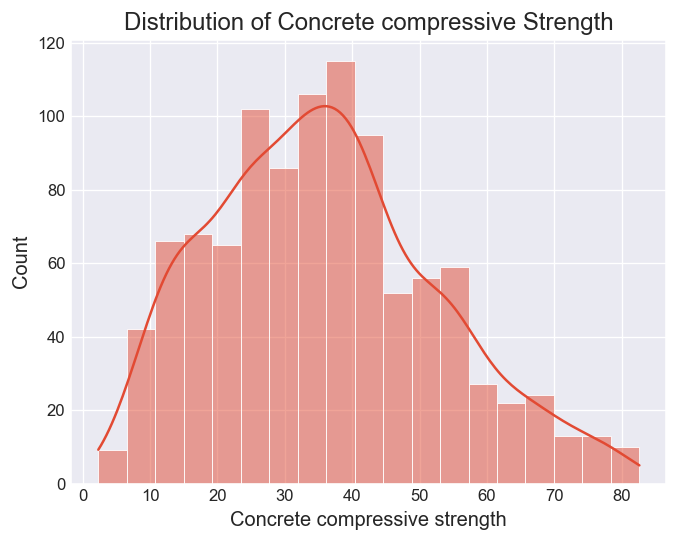

In [261]:
sns.histplot(concrete_df[label_column], kde=True)
plt.title("Distribution of Concrete compressive Strength")
plt.show()

The histogram plot clearly indicates that the compressive strength data is neither uniformly nor normally distributed. Instead, it exhibits a sporadic and spread-out pattern, with many unique or infrequent strength values and some concentration toward the distribution’s tails.

This lack of strong central tendency suggests that assumption-heavy models, such as simple linear regression, may not perform optimally. Therefore, it is advisable to consider more robust models such as decision trees. While linear regression can still be applied as a baseline, the observed distribution helps explain its potential limitations in predictive performance.

### 2.8. Correlation between relevant variables

To explore the linear relationships among the variables, a correlation matrix is computed and visualized using a heatmap. This analysis highlights both the correlations between input features and the target variable, as well as potential multicollinearity among the input variables.

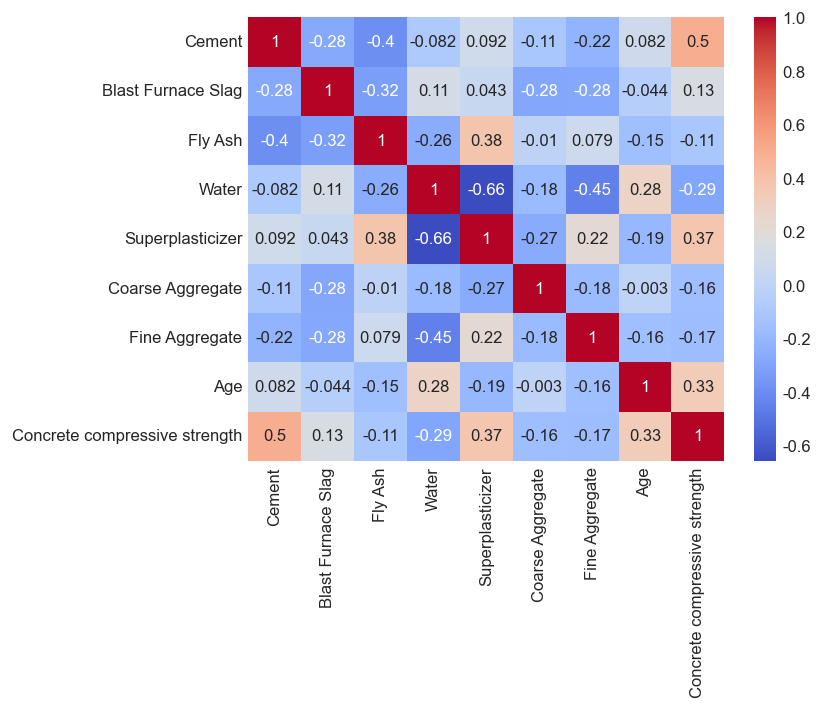

In [262]:
corr = concrete_df.corr(numeric_only=True) # Calculate correlation matrix
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

#### 2.8.1. Variables that influence concrete strength

According to the heatmap results, `cement` has a moderately strong positive correlation with concrete strength, with a value of +0.50. This indicates that more cement usually leads to stronger concrete. `Superplasticiser` also has a positive effect, with a value of +0.37.
`Age` also has a positive effect, as concrete strengthens over time.
`Water` has a negative correlation with strength of -0.29, meaning more water tends to weaken concrete. This observation is consistent with **Abrams' water-to-cement ratio pronouncement**, which emphasises that an increased water-to-cement ratio typically reduces concrete strength.

#### 2.8.2. Multicollinearity

The highest level of multicollinearity is found in the correlation between `water` and `superplasticiser`, which has a value of -0.66. This indicates that they carry overlapping yet opposing information. There is also a moderate correlation between `cement`, `blast furnace slag` and `fly ash` because these materials may act as partial substitutes in the concrete mix and therefore tend to move in opposite directions.

To gain a more precise understanding of potential collinearity among the input variables, we compute the **Variance Inflation Factor (VIF)** for each predictor. **VIF** quantifies how much the variance of a regression coefficient is inflated due to the linear dependence of that variable on the others. It serves as a diagnostic tool to detect multicollinearity, which can adversely affect the interpretability and stability of regression models. As mentioned in the Machine Learning and Data Analytics (MLDA) lecture content, a **VIF** of 1 shows an absence of collinearity, whereas collinearity usually occurs when the **VIF** is greater than 5.

In [263]:
VIFs = [(predictor, variance_inflation_factor(X,_)) \
        for _,predictor in enumerate(list(feature_columns))] # Calculate VIFs
print('Variance Inflation Factors')
for tup in VIFs:
    print('{:20}'.format(tup[0]), '{:.3f}'.format(tup[1]))

Variance Inflation Factors
Cement               15.457
Blast Furnace Slag   3.329
Fly Ash              4.148
Water                82.158
Superplasticizer     5.471
Coarse Aggregate     84.956
Fine Aggregate       72.791
Age                  1.699


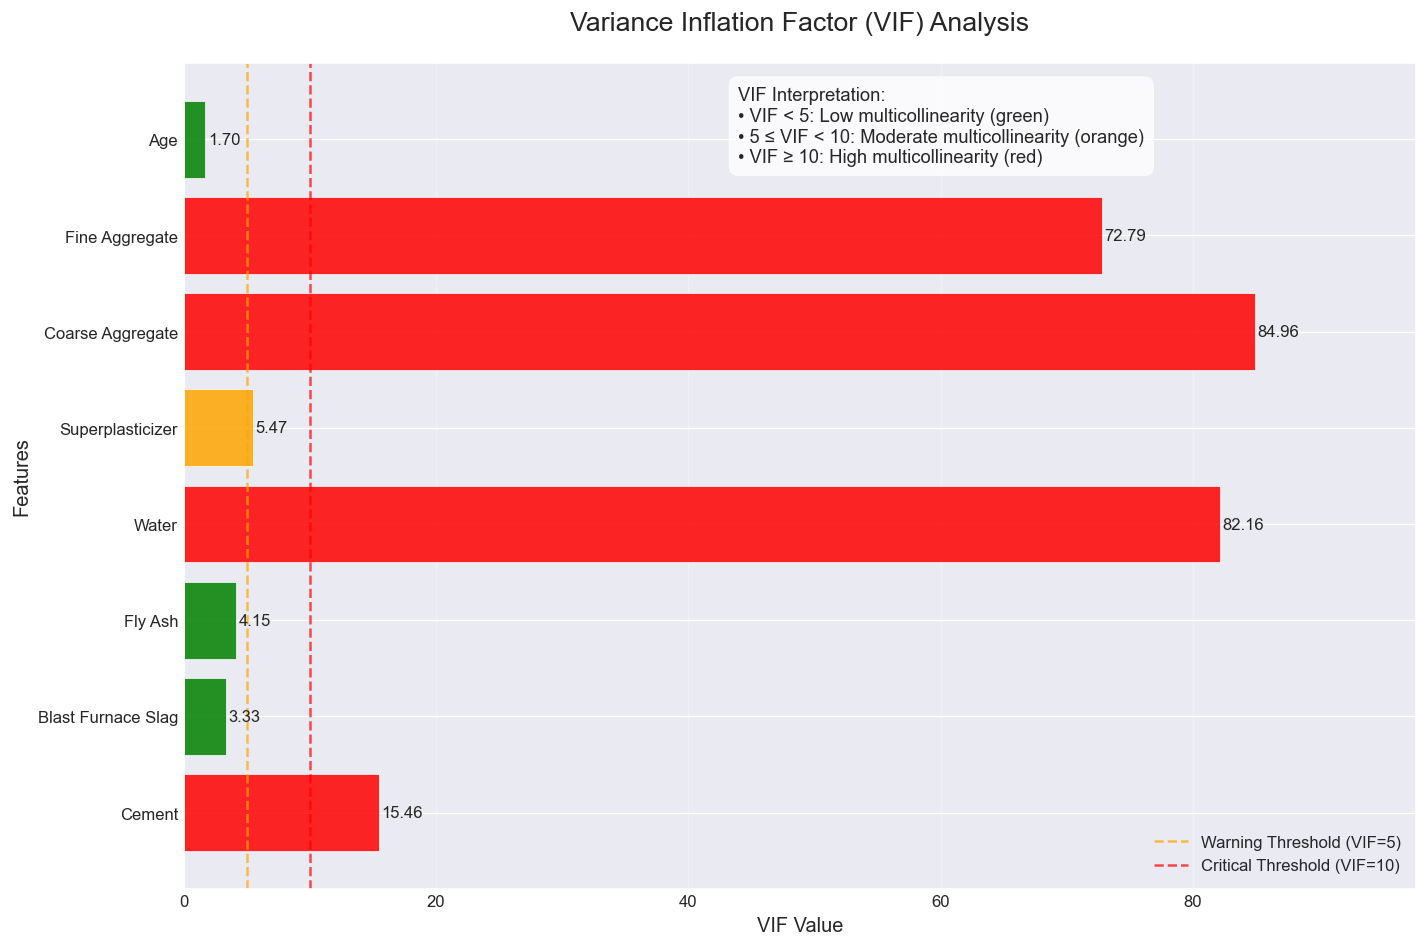

In [264]:
features = [tup[0] for tup in VIFs]
vif_values = [tup[1] for tup in VIFs]

colors = ['red' if v > 10 else 'orange' if v > 5 else 'green' for v in vif_values]

plt.figure(figsize=(12, 8))

bars = plt.barh(features, vif_values, color=colors, alpha=0.85)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.2,  
             bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', 
             va='center', ha='left',
             fontsize=10)

plt.axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='Warning Threshold (VIF=5)')
plt.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='Critical Threshold (VIF=10)')

plt.title('Variance Inflation Factor (VIF) Analysis', fontsize=16, pad=20)
plt.xlabel('VIF Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xlim(0, max(vif_values) * 1.15)  

plt.legend(loc='lower right')
plt.grid(axis='x', alpha=0.3)

plt.text(0.45, 0.88,  
         'VIF Interpretation:\n'
         '• VIF < 5: Low multicollinearity (green)\n'
         '• 5 ≤ VIF < 10: Moderate multicollinearity (orange)\n'
         '• VIF ≥ 10: High multicollinearity (red)',
         transform=plt.gca().transAxes,  
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
         fontsize=11)

plt.tight_layout()
plt.show()

As shown in the table above, the variance inflation factors (VIFs) are notably high for `coarse aggregate`, `water`,`fine aggregate`,`cement`, `superplasticizer`, `fly ash` and `blast furnace slag`. This indicates a substantial degree of multicollinearity among these input variables.

## 3. Experiments

This project aims to predict concrete compressive strength which is a problem with a quantitative response. According to the lecture content in the fundamental part of MLDA, this task is a **regression task**. In the following part, cross validation, stasmodels, scikit-models and tree-based methods are applied. 

Before applying various regression techniques, cross-validation was adopted as a fundamental evaluation strategy to ensure model generalizability across all experiments. Several regression models were in evaluated, including **statsmodel**, **scikit-model** and **tree-based methods**. **Statsmodels** were first employed to fit a linear model and analyze diagnostic plots, which revealed the presence of outliers and high leverage points. Subsequently, **scikit-models** are applied starting with a **basic linear regression**. However, the results indicated only a moderate fit. Combined with the earlier statistical findings that suggested potential non-linearity in the data, we proceeded to **polynomial regression** to better capture the underlying structure. **Polynomial regression** yielded promising results. To further enhance model performance, additional approaches were explored, including feature selection via **forward stepwise selection** and regularization techniques such as **Ridge and Lasso**. However, **feature selection** resulted in an increased MSE and a slight drop in R² on the test set. In contrast, regularization methods such as **Ridge** and **Lasso** provided comparable improvements. In particular, **Lasso** applied a thresholding mechanism that further narrowed the gap between training and test performance, thereby enhancing model robustness. In parallel, **tree-based methods**, including **Decision Tree**, **Random Forest**, and **Gradient Boosting**, were explored to further optimize prediction accuracy.

### 3.1. Cross validation

#### 3.1.1 Validation set approach

In supervised machine learning, the objective is to develop a model that performs well not only on the training data but also on previously unseen data. To evaluate this generalization ability, the dataset is split into a **training set** (80%) and a **test set** (20%).

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True)

#### 3.1.2. K-fold cross validation

To evaluate the model more reliably, the **K-fold method** is used. In this approach, the data is split into 10 parts; each part is used once as the validation set while the remaining parts form the training set. The results from all K iterations are then averaged to reduce the bias from a single split.

In [266]:
# define the kfold, shuffle the training and test dataset every time
kf = KFold(n_splits=10, random_state = 0, shuffle = True)

#### 3.1.3. Scorers for the model

To evaluate the performance of the model during cross-validation, two standardized scoring metrics are employed: the **Mean Squared Error (MSE)** and the **coefficient of determination**, denoted as **R²**. The **MSE** quantifies the average of the squared differences between the predicted and the actual values, with lower values indicating a more accurate model fit. In contrast, the **R² score** assesses the proportion of variance in the dependent variable that is predictable from the independent variables, where values approaching 1 imply stronger explanatory and predictive capabilities. To ensure consistency in their application within the evaluation framework, both metrics are encapsulated using the `make_scorer()` function, thereby facilitating their integration into subsequent model assessment procedures.

In [267]:
# Create MSE scorer 
mse_scorer = make_scorer(mean_squared_error)

# Create r2 scorer 
r2 = make_scorer(r2_score)

#### 3.1.4. Define a dataframe with all evaluation results

Create a DataFrame named `model_results_df` and define a function to append each model’s evaluation results for subsequent analysis.
This provides a structured and consistent way to collect evaluation metrics, enabling efficient comparison across multiple models. The inclusion of the `R2_Gap` metric further helps identify potential overfitting or underfitting issues.

In [268]:
columns = ['Model', 'R2', 'MSE', 'Test_R2', 'Test_MSE', 'R2_Gap']
model_results_df = pd.DataFrame(columns=columns)

# define a funktion to append the result into model_results_df
def record_model_results(results_df, model_name, train_r2, train_mse, test_r2, test_mse):
    
    r2_gap = train_r2 - test_r2
    
    new_row = pd.DataFrame([{
        'Model': model_name,
        'R2': train_r2,
        'MSE': train_mse,
        'Test_R2': test_r2,
        'Test_MSE': test_mse,
        'R2_Gap': r2_gap
    }])
    
    if model_name in results_df['Model'].values:
        idx = results_df.index[results_df['Model'] == model_name].tolist()[0]
        results_df.loc[idx] = new_row.iloc[0]
    else:
        results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    return results_df

### 3.2. Explanation of the dataset with statsmodel

#### 3.2.1. Ordinary Least Squares (OLS) model fitting and summary statistics

To gain statistical insights into the impact of individual input features on concrete compressive strength, an **Ordinary Least Squares (OLS)** regression model is fitted using the statsmodels library. 

To prepare the data for OLS regression, the feature matrix `X_stat` is constructed by selecting all input variables from the dataset and appending a constant term to account for the intercept. The target variable `y_stat` corresponds to the concrete compressive strength. The results of the regression analysis — estimated coefficients, standard errors, and statistical significance — are summarized in the table below, based on the OLS method.

In [269]:
#Statsmodel fitting, it is used to show the p-values
X_stat = sm.add_constant(concrete_df.iloc[:,0:-1])
y_stat = concrete_df[label_column]

statmodel = sm.OLS(y_stat,X_stat)
estimate = statmodel.fit()

print(estimate.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Concrete compressive strength   R-squared:                       0.616
Model:                                       OLS   Adj. R-squared:                  0.613
Method:                            Least Squares   F-statistic:                     204.3
Date:                           Thu, 17 Jul 2025   Prob (F-statistic):          6.29e-206
Time:                                   16:07:17   Log-Likelihood:                -3869.0
No. Observations:                           1030   AIC:                             7756.
Df Residuals:                               1021   BIC:                             7800.
Df Model:                                      8                                         
Covariance Type:                       nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------

Based on the result of the fitted model, a statistically significant relationship is observed between `concrete compressive strength` and several input variables, namely `cement`, `blast furnace slag`, `fly ash`, `water`, `superplasticizer`, and `age`, as indicated by their respective **p-values** being below the conventional threshold of **0.05**.

The fitted OLS model yields an **R-squared value** of approximately 0.62, indicating that around 62% of the variance in concrete compressive strength can be explained by the selected predictors. This suggests a moderate level of explanatory power. The **adjusted R-squared**, which accounts for the number of predictors in the model, supports this conclusion. The **F-statistic** is relatively high, and the **corresponding p-value** is close to zero, confirming that the model as a whole is statistically significant and that the predictors are jointly informative.

However, some diagnostic indicators point to potential issues. The **Omnibus test** suggests minor deviations from normality in the residuals, while the **Durbin-Watson statistic** is below 2, indicating the presence of positive autocorrelation. Although these issues are not severe, they may affect the model's reliability. 

Consequently, in the next step, regularized regression techniques such as Ridge or Lasso will be explored to mitigate multicollinearity and enhance predictive performance. Prior to that, all features will be standardized, and the models will be implemented using **scikit-learn**.

#### 3.2.2. Outliers and high leverage points

To assess the influence of individual data points on the fitted model, diagnostic measures are computed. In particular, the fitted values, residuals, studentized residuals, and leverage values are extracted from the OLS estimation.


In [270]:
# Obtain the residuals, studentized residuals and the leverages
fitted_values = estimate.fittedvalues
residuals = estimate.resid.values
studentized_residuals = OLSInfluence(estimate).resid_studentized_internal
leverages = OLSInfluence(estimate).influence

Based on these quantities, thresholds are then defined to preliminarily identify influential observations. Data points with absolute studentized residuals greater than 3 are flagged as potential **outliers**, while those with leverage values exceeding the theoretical threshold of $(p+1)/n$ (where $p$ is the number of predictors and $n$ the sample size) are classified as **high-leverage points**.


The three diagnostic plots respectively display:

(1) **raw residuals versus fitted values**

(2) **studentized residuals versus fitted values**

(3) **studentized residuals versus leverage values**

Each plot is used to visually identify potential outliers and high-leverage observations based on predefined statistical thresholds.

Outliers are: [np.int64(381), np.int64(383)]
Comments on joint outliers (in both ax2 and ax3): [np.int64(381), np.int64(383)]


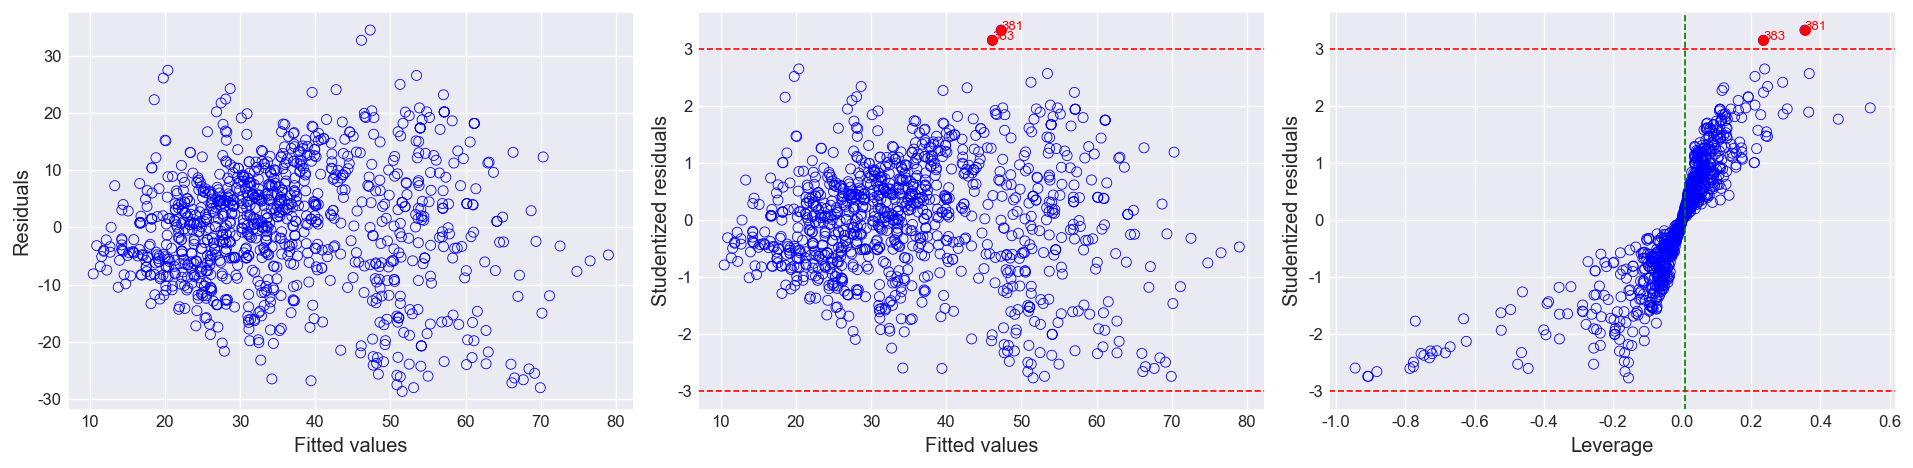

In [271]:
# Calculate thresholds
n = len(fitted_values)
p = X.shape[1] - 1  # exclude constant
leverage_thresh = (p + 1) / n

# Convert to arrays
studentized_residuals = np.asarray(studentized_residuals)
leverages = np.asarray(leverages)

# Identify outlier indices
outlier_indices = np.where(np.abs(studentized_residuals) > 3)[0]
high_leverage_indices = np.where(leverages > leverage_thresh)[0]
outliers = []
for idx in outlier_indices:
    outliers.append(idx)
print("Outliers are:",outliers)

# Find common indices (both outlier and high leverage)
joint_outliers = np.intersect1d(outlier_indices, high_leverage_indices)
high_leverage_and_outliers = [] 

for idx in joint_outliers:
    high_leverage_and_outliers.append(idx)
print("Comments on joint outliers (in both ax2 and ax3):",high_leverage_and_outliers)


# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# 1. Residuals plot
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')

# 2. Studentized Residuals plot
ax2.scatter(fitted_values, studentized_residuals, facecolors='none', edgecolors='b')
ax2.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax2.axhline(y=-3, color='r', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax2.scatter(fitted_values[idx], studentized_residuals[idx], color='red')
    ax2.annotate(idx, (fitted_values[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Studentized residuals')

# 3. Leverage vs Studentized Residuals
ax3.scatter(leverages, studentized_residuals, facecolors='none', edgecolors='b')
ax3.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax3.axhline(y=-3, color='r', linestyle='--', linewidth=1)
ax3.axvline(x=leverage_thresh, color='g', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax3.scatter(leverages[idx], studentized_residuals[idx], color='red')
    ax3.annotate(idx, (leverages[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax3.set_xlabel('Leverage')
ax3.set_ylabel('Studentized residuals')

plt.tight_layout()
plt.show()



The residual plot exhibits a discernible pattern, indicating potential **non-linearity** in the data, which may violate the assumptions of the linear regression model. The studentized residuals reveal the presence of two influential observations that exceed the conventional threshold for **outlier detection**. In parallel, the leverage plot identifies several **high-leverage points** — defined as observations with leverage values exceeding the theoretical cutoff. Notably, both identified outliers also possess high leverage.

However, given the absence of predefined exclusion criteria within the dataset, all observations — including these joint outliers — are retained for subsequent analysis to preserve data integrity.



### 3.3. Prediction with scikit model

#### 3.3.1. Linear regression

To evaluate the performance of a linear regression model, the data is first preprocessed by scaling features. A pipeline combining this preprocessing step with linear regression is then constructed. The model's predictive accuracy is assessed via K-fold cross-validation, reporting the average MSE and coefficient of determination (R²) across all folds.

In [272]:
#Preprocess data by scaling features
scaler = StandardScaler()
model = make_pipeline(scaler, LinearRegression())

mse_scores_lin = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)

print("\nAverage MSE across folds:", -np.mean(mse_scores_lin))
print("\nAverage R2 across folds:", np.mean(r2_scores))


Average MSE across folds: 113.39808429409462

Average R2 across folds: 0.5901000482034882


Next, the **validation set approach** is employed. The model is first trained on the training set, and predictions are subsequently made on both the training and test sets. The MSE and R² are computed for each set, providing insight into the model’s fit on the training data as well as its ability to generalize to unseen data.

In [273]:
linear = model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

y_pred = linear.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R2: {test_r2:.4f}")

Test MSE: 95.6172
Test R2: 0.6370


While the test MSE indicates an acceptable level of prediction error, the R² score of 0.637 reveals that the linear regression model only moderately fits the data. Although a significant portion of the variance is explained, the result also suggests that linear relationships alone may not fully capture the complexity of the target variable. To address this, polynomial features will be introduced to model potential non-linear patterns, followed by regularized regression techniques such as Ridge and Lasso to improve generalization and mitigate multicollinearity.

In [274]:
# append the result to Dataframe
model_name = 'Basic Linear Regression'
model_results_df = record_model_results(
    model_results_df,
    model_name,
    train_r2,
    train_mse,
    test_r2,
    test_mse
)

C:\Users\DrMUAPOR\AppData\Local\Temp\ipykernel_15348\4174503737.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


#### 3.3.2. Polynomial regression

In this section, polynomial regression is used because there is non-linearity between the features and the target variable. To prevent overfitting due to using excessively high polynomial degrees, we evaluate models with varying degrees and select the one with the lowest MSE. This optimal degree is then used for further analysis.

In [275]:
# Try polynomial features with degree 2 to 4
# Store MSE scores for each degree
degree_mse = {}

# Loop through polynomial degrees from 2 to 4
for degree in range(2, 5):
    model_poly = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linreg', LinearRegression())
    ])

    mse_scores = cross_val_score(model_poly, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
    avg_mse = -np.mean(mse_scores)

    degree_mse[degree] = avg_mse
    print(f"Degree {degree}: Average MSE = {avg_mse:.4f}")
    

# Find the degree with the lowest MSE
best_degree = min(degree_mse, key=degree_mse.get)
print(f"\nBest polynomial degree: {best_degree} (MSE = {degree_mse[best_degree]:.4f})")

Degree 2: Average MSE = 60.9221
Degree 3: Average MSE = 50.4839


Degree 4: Average MSE = 133943.6228

Best polynomial degree: 3 (MSE = 50.4839)


Among the degrees compared, the polynomial regression model with degree 3 achieved the lowest average MSE with respect to the training dataset, with a value of 50.48.

In [276]:
poly = PolynomialFeatures(degree = best_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Fit the model with the best polynomial degree
model = LinearRegression()
model.fit(X_train_poly_scaled, y_train)

# Prediction on the train set
y_train_pred = model.predict(X_train_poly_scaled)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Make predictions on the test set
y_test_pred = model.predict(X_test_poly_scaled)

# Calculate MSE and R2 for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
r2_gap = train_r2 - test_r2

print(f"Test MSE: {test_mse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Test MSE: 51.12
Test R2: 0.81


The training MSE and the test MSE are very close with training MSE equal to 50.48 and test MSE as 51.12. This indicates that the model generalizes well to unseen data and is not just memorizing the training set. Hence, there is no significant overfitting. If the model were overfitting, we would expect the training MSE to be much lower than the test MSE.
So for follwing analyzing the degree equal to 3 will be used.

In [277]:
# append the result to Dataframe
model_name = f"Polynomial Regression (degree: {best_degree})"

model_results_df = record_model_results(
    model_results_df,
    model_name,
    train_r2,
    train_mse,
    test_r2,
    test_mse
)

#### 3.3.3. Forward stepwise selection

In this step, we perform a forward stepwise selection to determine the best set of features at first. As the criterion for the comparison of the different models, we also estimate the metrics using 10-fold cross validation in this model.

In [278]:
def forward_stepwise_selection_mse_r2(X, y, max_features=None):
    n_features = X.shape[1]
    selected = []
    remaining = list(range(n_features))
    best_mse_list = []
    best_r2_list = []
    
    if max_features is None:
        max_features = n_features

    while len(selected) < max_features:
        candidates = []
        for candidate in remaining:
            features = selected + [candidate]
            model = LinearRegression()
            mse = -np.mean(cross_val_score(model, X[:, features], y, scoring='neg_mean_squared_error', cv=kf))
            r2 = np.mean(cross_val_score(model, X[:, features], y, scoring='r2', cv=kf))
            candidates.append((mse, r2, candidate))

        # choose the minimum of mse
        candidates.sort()
        best_mse, best_r2, best_candidate = candidates[0]

        selected.append(best_candidate)
        remaining.remove(best_candidate)
        best_mse_list.append(best_mse)
        best_r2_list.append(best_r2)

    return selected, best_mse_list, best_r2_list

In [279]:
# polynomial features with degree 3
poly = PolynomialFeatures(degree=best_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
forward_feature_names = poly.get_feature_names_out(input_features  = feature_columns)

selected_features, mse_list, r2_list= forward_stepwise_selection_mse_r2(X_train_poly, y_train)
#print(selected_features, mse_list)

In [280]:
current_selection = []
best_index = np.argmin(mse_list)
for i, (mse, r2, feature_idx) in enumerate(zip(mse_list, r2_list, selected_features), 1):
    current_selection.append(feature_idx)
    forward_selected_names = [forward_feature_names[j] for j in current_selection]
    if i == best_index + 1:
        print(f"Best MSE: {mse:.4f} | Best R²: {r2:.4f} | Features: {forward_selected_names}")
        break

Best MSE: 33.0234 | Best R²: 0.8812 | Features: ['Water Coarse Aggregate Fine Aggregate', 'Coarse Aggregate Fine Aggregate Age', 'Fine Aggregate Age^2', 'Cement Coarse Aggregate Fine Aggregate', 'Cement Blast Furnace Slag Fine Aggregate', 'Cement Fly Ash Age', 'Fly Ash Age^2', 'Age^3', 'Age^2', 'Age', 'Fine Aggregate^2 Age', 'Fine Aggregate Age', 'Water^2 Coarse Aggregate', 'Cement^2 Coarse Aggregate', 'Superplasticizer^3', 'Superplasticizer Coarse Aggregate Fine Aggregate', 'Superplasticizer^2', 'Blast Furnace Slag Fly Ash Age', 'Blast Furnace Slag Water^2', 'Cement Blast Furnace Slag Superplasticizer', 'Cement Coarse Aggregate', 'Water^3', 'Water Coarse Aggregate', 'Blast Furnace Slag Fine Aggregate Age', 'Blast Furnace Slag Age^2', 'Superplasticizer Age^2', 'Superplasticizer Fine Aggregate Age', 'Cement Fly Ash^2', 'Blast Furnace Slag^3', 'Blast Furnace Slag Superplasticizer Age', 'Cement^2 Fly Ash', 'Fly Ash^3', 'Water Superplasticizer Fine Aggregate', 'Coarse Aggregate^2', 'Water^

In [281]:
model = LinearRegression().fit(X_train_poly[:, current_selection], y_train)
y_pred = model.predict(X_test_poly[:, current_selection])
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f" Test MSE: {test_mse:.4f} | Test R²: {test_r2:.4f}")

 Test MSE: 47.5561 | Test R²: 0.8194


The model achieved its best performance with a training MSE of 33.0234 and a training R² score of 0.8812, indicating strong predictive accuracy on the training data. For this best-performing model , 66 features were used, many of which are polynomial combinations and interaction terms derived from the original variables. Notable examples include polynomial features such as Age², Age³, Superplasticizer³, and Water², as well as interaction terms like Cement × Fly Ash × Age, Water × Coarse Aggregate, and Blast Furnace Slag × Fly Ash × Fine Aggregate.

With these engineered features, the model achieved a test MSE of 47.5561 and a test R² of 0.8194. While the performance on the test set remains strong, the increase in MSE and the slight drop in R² compared to the training results suggest that the model may be overfitting due to the large number of features included.

To address this issue, in sections 3.3.4 and 3.3.5, we apply shrinkage methods, specifically Ridge and Lasso regression, to reduce the risk of overfitting by penalizing model complexity and encouraging simpler, more generalizable models.

#### 3.3.4. Ridge regression

In [282]:
scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}

# define the model
ridgemodel = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = best_degree),
    GridSearchCV(
        estimator = Ridge(),
        cv = kf,
        scoring = scoring,
        refit = 'neg_mean_squared_error', # redit the model based on the mse
        
        # param_grid determines the parameters to test (alpha is lambda in the Ridge estimator)
        # np.logspace(-3, 2, 50): array from 10^-3 to 10^2 in 50 steps (base default is 10, can also be something else)
        param_grid = {'alpha': np.logspace(-3, 2, 50)},
    )
)
ridgemodel.fit(X_train, y_train)
#print(ridgemodel[2].cv_results_) #to show the results and names

# obtain the results
lambdas = [p['alpha'] for p in ridgemodel[2].cv_results_['params']]
mses = [neg_mse * -1 for neg_mse in ridgemodel[2].cv_results_['mean_test_neg_mean_squared_error']]
r2 = [r2 for r2 in ridgemodel[2].cv_results_['mean_test_r2']]
    
best_model = ridgemodel.named_steps['gridsearchcv'].best_estimator_
best_mse = min(mses)
best_r2 = max(r2)

best_lambda_mse = lambdas[np.argmin(mses)]
best_lambda_r2 = lambdas[np.argmax(r2)]

print(f"Best alpha regarding mse: {best_lambda_mse:.2f}, with MSE: {best_mse:.2f}")
print(f"Best alpha regarding r2: {best_lambda_r2:.2f}, with r2: {best_r2:.2f}")
model

Best alpha regarding mse: 0.91, with MSE: 36.54
Best alpha regarding r2: 0.91, with r2: 0.87


LinearRegression()

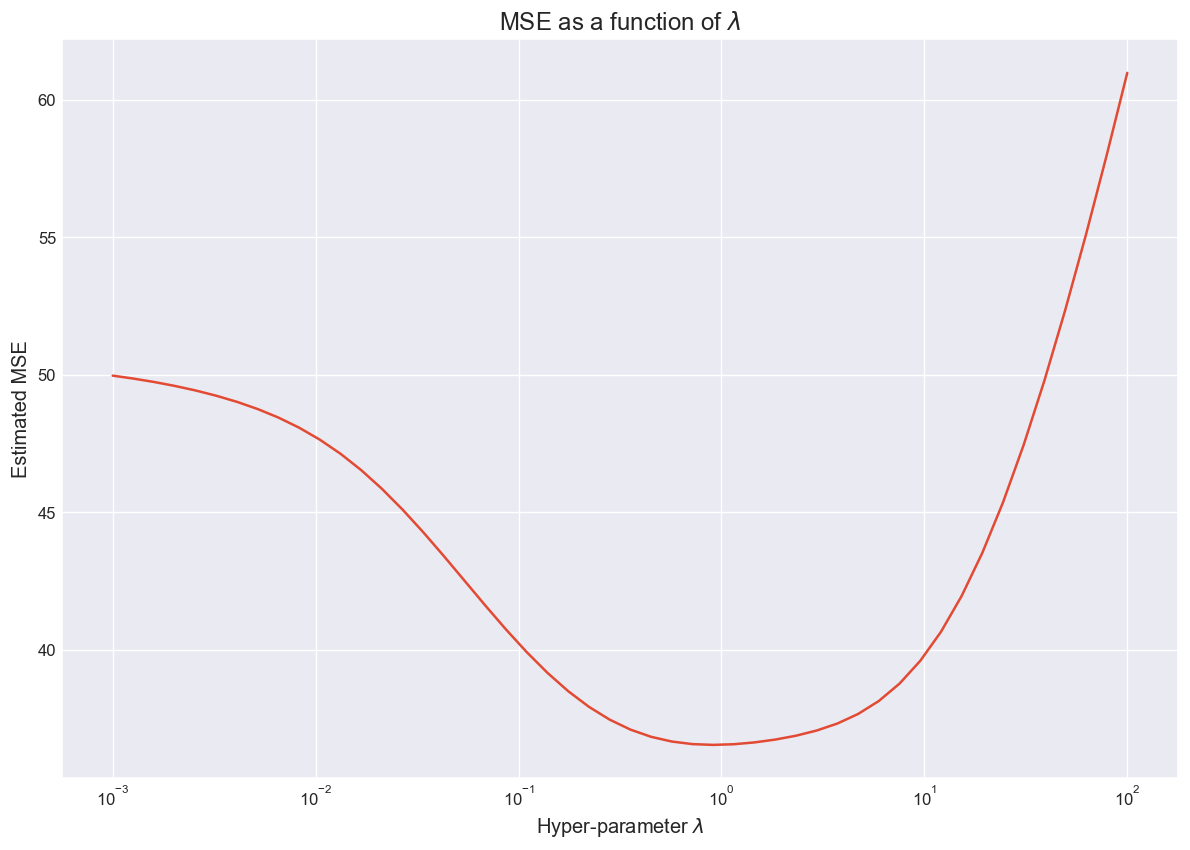

In [283]:
# plot the reults
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");
plt.show()

In [284]:
y_train_pred = ridgemodel.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = ridgemodel.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

r2_gap = train_r2 - test_r2
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Test MSE: 45.19
Test R2: 0.83


Ridge regression was evaluated across a range of λ values from $10^{-3}$ to $10^2$. The validation MSE decreased with small increases in λ due to reduced overfitting, reaching a minimum at λ = 0.91. Beyond this point, further increases in λ caused the model to underfit the data, resulting in higher MSEs.
Thus, the optimal λ value was selected as 0.91, where the model achieved the lowest MSE of 36.54 and a training R² score of 0.87.

On the test set, the model achieved a Test MSE of 45.19 and a Test R² score of 0.83.
Although the evaluation scores on the training set slightly dropped, the test set showed better MSE and R² values, indicating that the model's accuracy improved with Ridge regression.

In [285]:
model_name = f"Ridge (alpha={best_lambda_mse:.4f})"

# append the result to Dataframe
model_results_df = record_model_results(
    model_results_df,
    model_name,
    train_r2,
    train_mse,
    test_r2,
    test_mse
)

#### 3.3.5. Lasso regression

c:\Users\DrMUAPOR\Documents\Uni\ss25\Machine Learning and Data Analytics\Code\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e+03, tolerance: 2.108e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\DrMUAPOR\Documents\Uni\ss25\Machine Learning and Data Analytics\Code\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+03, tolerance: 2.122e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\DrMUAPOR\Documents\Uni\ss25\Machine Learning and Data Analytics\Code\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objecti

Best alpha regarding mse: 0.010, with MSE: 36.00
Best alpha regarding r2: 0.010, with R2: 0.871


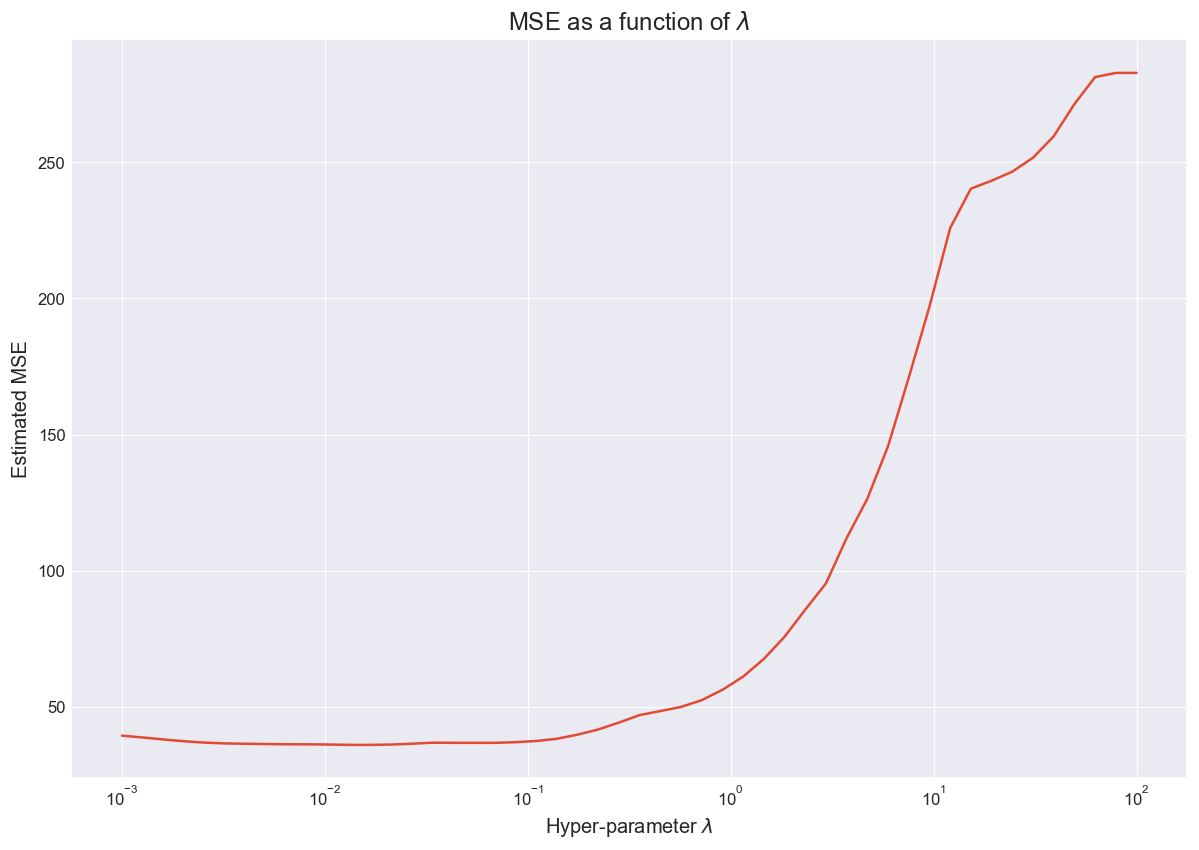

In [286]:
# Define the pipeline with GridSearchCV
lassomodel = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = best_degree, interaction_only=False, include_bias=False),
    GridSearchCV(
        estimator = Lasso(max_iter = 10000, tol = 1e-4),
        param_grid={'alpha': np.logspace(-3, 1.5, 50)},
        scoring=scoring,
        refit='neg_mean_squared_error',
        cv=kf
    )
)

# Fit the pipeline
lassomodel.fit(X_train, y_train)
#print(lassomodel[2].cv_results_)

# Extract CV results
grid = lassomodel.named_steps['gridsearchcv']
lassolambdas = [p['alpha'] for p in grid.cv_results_['params']]
mses_lasso = [-score for score in grid.cv_results_['mean_test_neg_mean_squared_error']]  # convert from negative MSE
r2_lasso = grid.cv_results_['mean_test_r2']

# Get best values
best_lassomodel = grid.best_estimator_
best_lassomse = min(mses_lasso)
best_lassor2 = max(r2_lasso)

best_lambda_mse_lasso = lassolambdas[np.argmin(mses_lasso)]
best_lambda_r2_lasso = lassolambdas[np.argmax(r2_lasso)]

print(f"Best alpha regarding mse: {best_lambda_mse_lasso:.3f}, with MSE: {best_lassomse:.2f}")
print(f"Best alpha regarding r2: {best_lambda_r2_lasso:.3f}, with R2: {best_lassor2:.3f}")

# plot the results
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses_lasso)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");

plt.show()

In [287]:
y_test_pred = lassomodel.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Test MSE: 42.10
Test R2: 0.84


In [288]:
y_train_pred = lassomodel.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

best_index = np.argmin(mses_lasso)
best_alpha = lassolambdas[best_index]
model_name = f"Lasso (alpha={best_alpha:.4f})"

# append the result to Dataframe
model_results_df = record_model_results(
    model_results_df,
    model_name,
    train_r2,
    train_mse,
    test_r2,
    test_mse
)

It can be observed that the test MSE and $R^2$ scores for the Lasso regression are similar to those obtained with Ridge regression. This is likely because the chosen regularization parameter ($\alpha = 0.010$) is relatively small, meaning the penalty applied by Lasso is weak and does not strongly constrain the model. As a result, Lasso behaves similarly to Ridge in this case.

The next step is to examine the coefficients from the Lasso model to determine which ones have been shrunk exactly to zero (indicating feature elimination) and which are merely close to zero (indicating minimal contribution). This analysis will help us understand the extent of sparsity introduced by the Lasso regularization.


##### 3.3.5.1. Non-zero coefficients

In [289]:
# Extract from the fitted polynomial step
poly = lassomodel.named_steps['polynomialfeatures']
feature_names = poly.get_feature_names_out(input_features = feature_columns)

# Get final fitted Lasso model
lasso = lassomodel.named_steps['gridsearchcv'].best_estimator_

# Get coefficients
coefs = lasso.coef_

# Combine with feature names
lasso_selected_features = [name for name, coef in zip(feature_names, coefs) if coef != 0]
zero_features = [(name, coef) for name, coef in zip(feature_names, coefs) if coef == 0]

print("Non-zero coefficients:", np.sum(lasso.coef_ != 0))
print("Total features:", len(lasso.coef_))
print("Zero coefficients:", zero_features)

lasso_weights = pd.Series(coefs, index=feature_names)
lasso_weights.sort_values(key=abs, ascending=False)  # sort by absolute value

Non-zero coefficients: 127
Total features: 164
Zero coefficients: [('Coarse Aggregate', np.float64(0.0)), ('Cement Fine Aggregate', np.float64(0.0)), ('Blast Furnace Slag^2', np.float64(-0.0)), ('Blast Furnace Slag Water', np.float64(0.0)), ('Blast Furnace Slag Superplasticizer', np.float64(0.0)), ('Blast Furnace Slag Coarse Aggregate', np.float64(0.0)), ('Fly Ash Coarse Aggregate', np.float64(0.0)), ('Fly Ash Fine Aggregate', np.float64(0.0)), ('Superplasticizer Coarse Aggregate', np.float64(0.0)), ('Coarse Aggregate Fine Aggregate', np.float64(-0.0)), ('Fine Aggregate Age', np.float64(0.0)), ('Cement^2 Superplasticizer', np.float64(0.0)), ('Cement Blast Furnace Slag^2', np.float64(-0.0)), ('Cement Blast Furnace Slag Age', np.float64(0.0)), ('Cement Fly Ash Superplasticizer', np.float64(-0.0)), ('Cement Water Coarse Aggregate', np.float64(-0.0)), ('Cement Water Fine Aggregate', np.float64(0.0)), ('Cement Superplasticizer Fine Aggregate', np.float64(0.0)), ('Cement Fine Aggregate Age',

Age                                        22.077625
Age^2                                     -15.956060
Superplasticizer Age^2                     -7.349535
Cement                                      7.163911
Water                                      -5.780027
                                             ...    
Water^2 Fine Aggregate                      0.000000
Water Superplasticizer Coarse Aggregate     0.000000
Superplasticizer Coarse Aggregate Age      -0.000000
Coarse Aggregate Fine Aggregate Age        -0.000000
Coarse Aggregate Fine Aggregate^2           0.000000
Length: 164, dtype: float64

From the total of 164 features, the Lasso model identified 127 with non-zero coefficients, indicating their significance and contribution to the prediction of the target variable. The remaining 37 features had their coefficients regularized to zero, effectively excluding them from the model. 

To further refine the model and reduce overfitting, we subsequently explored thresholds ranging from 0 to 2.5. This post-Lasso filtering aims to remove coefficients with minimal influence on the response variable, thereby enhancing model robustness.

In [290]:
# Polynomial features transformation
poly = PolynomialFeatures(degree = best_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
feature_names = poly.get_feature_names_out(feature_columns)

# Scale the features and apply polynomial transformation
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Define the Lasso model with GridSearchCV
best_lasso = grid.best_estimator_
coefs = pd.Series(best_lasso.coef_, index=feature_names)

# Thresholds for feature selection
thresholds = np.linspace(0, 2.5, 50)  # 50 thresholds from 0 to 2.5

# Store results
results = []

for threshold in thresholds:
    selected = coefs[np.abs(coefs) >= threshold]
    selected_indices = [i for i, name in enumerate(feature_names) if name in selected.index]
    lasso_threshold_selected_names = list(selected.index)  # get names from coef Series

    if len(selected_indices) == 0:
        continue  # skip if no features are selected

    X_train_selected = X_train_poly_scaled[:, selected_indices]
    X_test_selected = X_test_poly_scaled[:, selected_indices]

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # Train and test scores
    y_train_pred = model.predict(X_train_selected)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test_selected)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results.append({
        "threshold": threshold,
        "n_features": len(selected_indices),
        "train r2": train_r2,
        "test r2": test_r2,
        "train mse": train_mse,
        "test mse": test_mse,
        "selected_features": lasso_threshold_selected_names
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
# print(results_df)

#  find the best threshold based on train mse
best_row = results_df.loc[results_df['train mse'].idxmin()]
print("\nBest Threshold (by training MSE):")
print(best_row)


Best Threshold (by training MSE):
threshold                                                          0.0
n_features                                                         164
train r2                                                      0.932118
test r2                                                       0.805898
train mse                                                    19.161017
test mse                                                     51.122475
selected_features    [Cement, Blast Furnace Slag, Fly Ash, Water, S...
Name: 0, dtype: object


This model, selected based on minimum training MSE, uses a threshold of 0.0, meaning no coefficients were removed, It achieved a very high training $R^2 = 0.932$ and low training MSE = 19.16*, indicating an excellent fit to the training data.

However, the test $R^2 = 0.806$ and test MSE = 51.12 show that, while the model performs reasonably well on unseen data, there is a noticeable gap between training and test performance. This discrepancy suggests the model is likely **overfitting**.

In summary, although this model achieves the best possible fit on the training set, no feature reduction comes at the cost of reduced generalization, making it less ideal than simpler models with comparable or better test performance. So we wanted to put more value on minimizing the gap between training and test scores.

To better understand how model complexity affects generalization, the next step is to visualize the $R^2$ and MSE gap between training and testing across various coefficient thresholds.



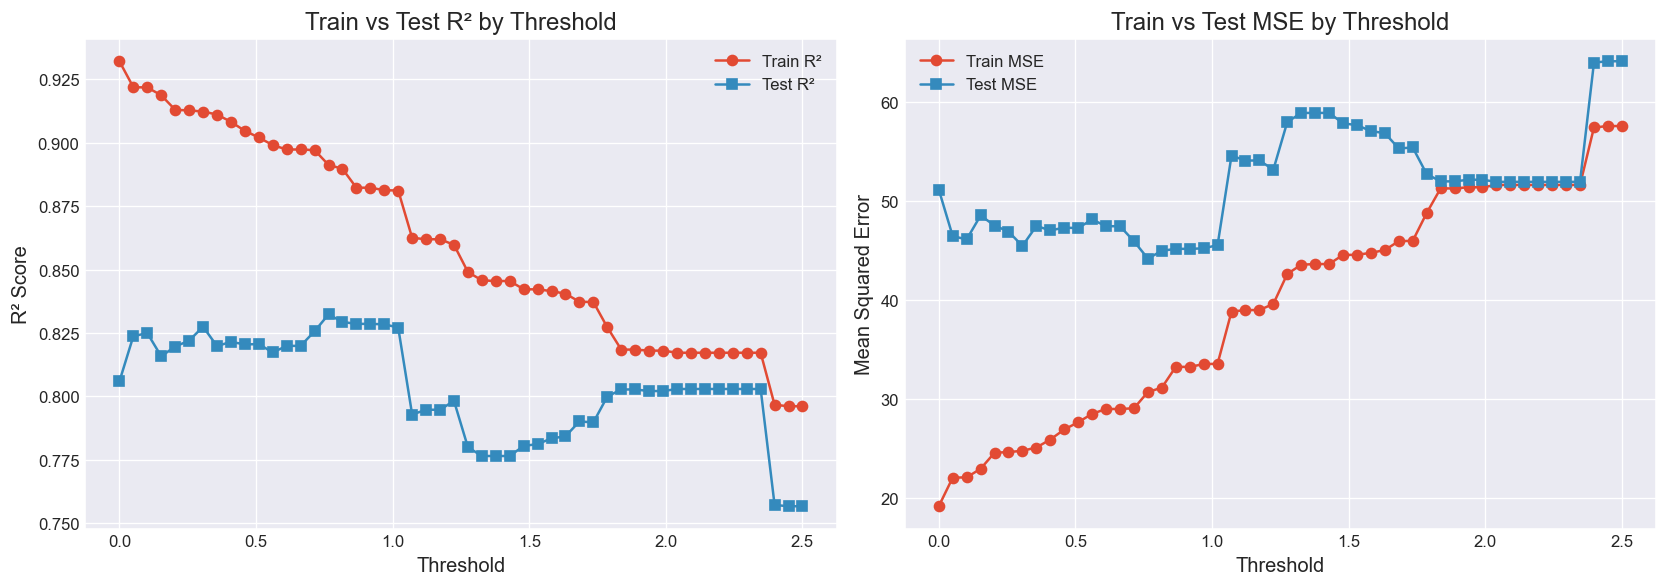

In [291]:
plt.figure(figsize=(14, 5))

# R²
plt.subplot(1, 2, 1)
plt.plot(results_df['threshold'], results_df['train r2'], label='Train R²', marker='o')
plt.plot(results_df['threshold'], results_df['test r2'], label='Test R²', marker='s')
plt.xlabel('Threshold')
plt.ylabel('R² Score')
plt.title('Train vs Test R² by Threshold')
plt.legend()
plt.grid(True)

# MSE
plt.subplot(1, 2, 2)
plt.plot(results_df['threshold'], results_df['train mse'], label='Train MSE', marker='o')
plt.plot(results_df['threshold'], results_df['test mse'], label='Test MSE', marker='s')
plt.xlabel('Threshold')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test MSE by Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [292]:
# calculate the R² and MSE gap
results_df['r2 gap'] = np.abs(results_df['train r2'] - results_df['test r2'])
results_df['mse gap'] = np.abs(results_df['train mse'] - results_df['test mse'])

# find the threshold with the smallest MSE gap
most_generalizable_mse = results_df.loc[results_df['mse gap'].idxmin()]

# after finding most generalizable mse

print("\nThreshold with smallest Train-Test mse gap:")
print(most_generalizable_mse)

smallest_mse_gap_features = [name for name in most_generalizable_mse['selected_features']]
print("\nSelected Features at Smallest MSE Gap:", smallest_mse_gap_features)


Threshold with smallest Train-Test mse gap:
threshold                                                     2.040816
n_features                                                          24
train r2                                                      0.817229
test r2                                                       0.802934
train mse                                                    51.590579
test mse                                                     51.903059
selected_features    [Cement, Blast Furnace Slag, Water, Superplast...
r2 gap                                                        0.014294
mse gap                                                        0.31248
Name: 40, dtype: object

Selected Features at Smallest MSE Gap: ['Cement', 'Blast Furnace Slag', 'Water', 'Superplasticizer', 'Age', 'Blast Furnace Slag Age', 'Water Superplasticizer', 'Water Coarse Aggregate', 'Superplasticizer^2', 'Superplasticizer Age', 'Age^2', 'Cement^2 Fly Ash', 'Cement Fly Ash Coarse Aggrega

The best test R² was achieved at a threshold of ~2,04, with a test R² of 0.80, train R² of 0.82, and 24 features selected.
The smallest R² gap (between train and test) is 0.014,and the smallest MSE gap is 0.31.

Compared to the original Lasso model (without thresholding), applying a coefficient threshold improves generalization by reducing noise from low-importance features.
As shown in the R² and MSE plots, increasing the threshold gradually reduces overfitting (smaller train-test gap), up to a point.
However, too high a threshold (>2.45) leads to performance breakdown. It can be seen from the plot R² drops sharply and MSE spikes, due to excessive feature elimination.

##### 3.3.5.2. Features comparison from forward stepwise selection and two lasso models

In [293]:
# List to set conversion for feature comparison
set_lasso = set(lasso_selected_features)
set_thresh = set(smallest_mse_gap_features)
set_forward = set(forward_selected_names)


# common features
common_all = set_lasso & set_thresh & set_forward
print(f" Features selected by ALL methods:\n{common_all}", f"\n with" , len(common_all), "features")

# two-way intersections
print(f"\n Lasso ∩ Threshold:\n{set_lasso & set_thresh}", f"\n with" , len(set_lasso & set_thresh), "features")
print(f"\n Lasso ∩ Forward:\n{set_lasso & set_forward}", f"\n with" , len(set_lasso & set_forward), "features")
print(f"\n Threshold ∩ Forward:\n{set_thresh & set_forward}", f"\n with" , len(set_thresh & set_forward), "features"   )

# Specific features only in one method
print(f"\n Only in Lasso:\n{set_lasso - set_thresh - set_forward}", f"\n with" , len(set_lasso - set_thresh - set_forward), "features")
print(f"\n Only in Thresholding:\n{set_thresh - set_lasso - set_forward}", f"\n with" , len(set_thresh - set_lasso - set_forward), "features")
print(f"\n Only in Forward Stepwise:\n{set_forward - set_lasso - set_thresh}", f"\n with" , len(set_forward - set_lasso - set_thresh), "features")


 Features selected by ALL methods:
{'Age^2', 'Water', 'Cement^2 Fly Ash', 'Fly Ash Superplasticizer Fine Aggregate', 'Superplasticizer^2', 'Cement Fly Ash Age', 'Age', 'Water Coarse Aggregate', 'Superplasticizer Age^2'} 
 with 9 features

 Lasso ∩ Threshold:
{'Blast Furnace Slag Coarse Aggregate^2', 'Cement Fly Ash Age', 'Cement Superplasticizer Age', 'Cement Fly Ash Coarse Aggregate', 'Cement^2 Fly Ash', 'Fly Ash Superplasticizer Fine Aggregate', 'Superplasticizer^2', 'Cement', 'Water Coarse Aggregate', 'Blast Furnace Slag Age', 'Cement Fly Ash Fine Aggregate', 'Water', 'Blast Furnace Slag Fly Ash^2', 'Superplasticizer Age^2', 'Fly Ash Coarse Aggregate Fine Aggregate', 'Blast Furnace Slag Fly Ash Coarse Aggregate', 'Fly Ash Water Fine Aggregate', 'Superplasticizer Age', 'Water Superplasticizer', 'Blast Furnace Slag Water Coarse Aggregate', 'Age', 'Superplasticizer', 'Age^2', 'Blast Furnace Slag'} 
 with 24 features

 Lasso ∩ Forward:
{'Coarse Aggregate Age', 'Fly Ash Fine Aggregate^2'

Since several methods (Lasso, a custom Thresholding approach, and Forward Stepwise selection) are used in this section , this intersection approach is to compare their outcomes. The following table is used to illustrate the results of comparison.

| **#** | **Comparison**                   | **Feature Count**                     | **Description**                                                                                                                                                                                                  |
| ----: | -------------------------------- | ------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
|     1 | **Selected by All Methods**      | 9                                     | Features consistently selected by **Lasso**, **Thresholding**, and **Forward Stepwise**. These are the most robust and stable predictors, showing consistent importance across all selection strategies.         |
|     2 | **Lasso ∩ Thresholding**         | 24 (shared), 0 (only in Thresholding) | Features selected by **both Lasso and Thresholding**. Since Thresholding filters the Lasso-selected features based on coefficient magnitude, it cannot contribute additional features beyond Lasso.              |
|     3 | **Lasso ∩ Forward Stepwise**     | 52                                    | Features identified by **both Lasso and Forward Stepwise**. The agreement indicates a strong predictive signal, but not all were retained by Thresholding, suggesting some may contribute to overfitting.        |
|     4 | **Threshold ∩ Forward Stepwise** | 9                                     | Same as the features selected by **all methods**, reinforcing their reliability. Their selection by both Thresholding and Forward Stepwise highlights their stability across both filtering and greedy methods.  |
|     5 | **Only in Lasso**                | 60                                    | Features selected **only by Lasso**. These had small but non-zero coefficients after regularization, not meeting the threshold or being selected by Forward Stepwise. They may have weak or noise-driven impact. |
|     6 | **Only in Forward Stepwise**     | 12                                    | Features selected **only by Forward Stepwise**. These were added incrementally because they improved model performance, even if their individual effects were weak. Forward Stepwise is sensitive to such gains. |


The feature selection comparison revealed that **9 features** were consistently selected by **all three methods**—Lasso, Thresholding, and Forward Stepwise. These features are considered the most robust and reliable predictors, as they were repeatedly identified as important across different selection strategies.

The intersection between **Lasso and Thresholding** yielded **24 shared features**, with **no features selected exclusively by Thresholding**. This is expected, since Thresholding is applied on top of Lasso and can only **filter out** features, not add new ones. Therefore, these 24 features represent the **subset of Lasso-selected variables** that passed the coefficient threshold and are **deemed important for prediction** based on their influence on the response variable.

A substantial overlap of **52 features** was observed between **Lasso and Forward Stepwise**, indicating strong agreement between these two methods despite their different selection mechanisms. However, not all of these features were retained after Thresholding, which suggests that **using all 52 may introduce complexity or overfitting**, as some have relatively small contributions.

Finally, the features shared between **Thresholding and Forward Stepwise** are identical to those selected by all three methods, further emphasizing their stability and central importance in building a robust predictive model.


### 3.4. Tree-based methods

#### 3.4.1. Decision Tree


##### 3.4.1.1. Fitting and Visualization

For our regression task, we want to balance bias and variance, mitigating overfitting and improving generalization of our models.  

**Key characteristics of tree-based methods:**
- **Non-linearity:** They can capture complex, non-linear relationships between features and the target variable, which is particularly useful when the data does not conform to linear assumptions.
- **Interpretability:** Decision trees can provide a visual and intuitive representation of the decision-making process, making it easier to understand which features are most influential.
- **Robustness to feature scaling:** Unlike many linear models, tree-based methods do not require feature scaling or normalization.

In our task of predicting **concrete compressive strength**, the relationship between the mixture components and the resulting strength is highly non-linear and involves complex interactions. Previous analysis showed that **linear models** struggled to capture these patterns, as indicated by [residual plots](####-3.2.2.-Outliers-and-high-leverage-points) and moderate [R² values](###3.3.-Prediction-with-scikit-model). Besides **polynomial regression models** (esp. including **regularization techniques** like **Lasso**) Tree-based methods, such as decision trees, random forests and gradient boosting, are better-suited for this scenario because they adapt to non-linearities and variable interactions present in the data, are less sensitive to multicollinearity and outliers and provide direct measures of feature importance, allowing us to identify which variables most strongly influence our predictions.


A **regression tree** is fitted to the training data using the **MSE** as the **splitting criterion**. All input features are considered, and splits are performed only at nodes with more than 20 samples. The resulting tree structure is then visualized using the graphviz package, which generates a graphical representation of all nodes and their corresponding decision rules.

In [294]:
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin" # Adjust this path as needed for macOS users

In [295]:
#Fit a regression tree on the training data using the mse metric for splitting, considering all the features and splitting if there are more than 20 samples at a node
tree = DecisionTreeRegressor(criterion='squared_error', max_features=None, min_samples_split=20)

tree_est = tree.fit(X_train, y_train)

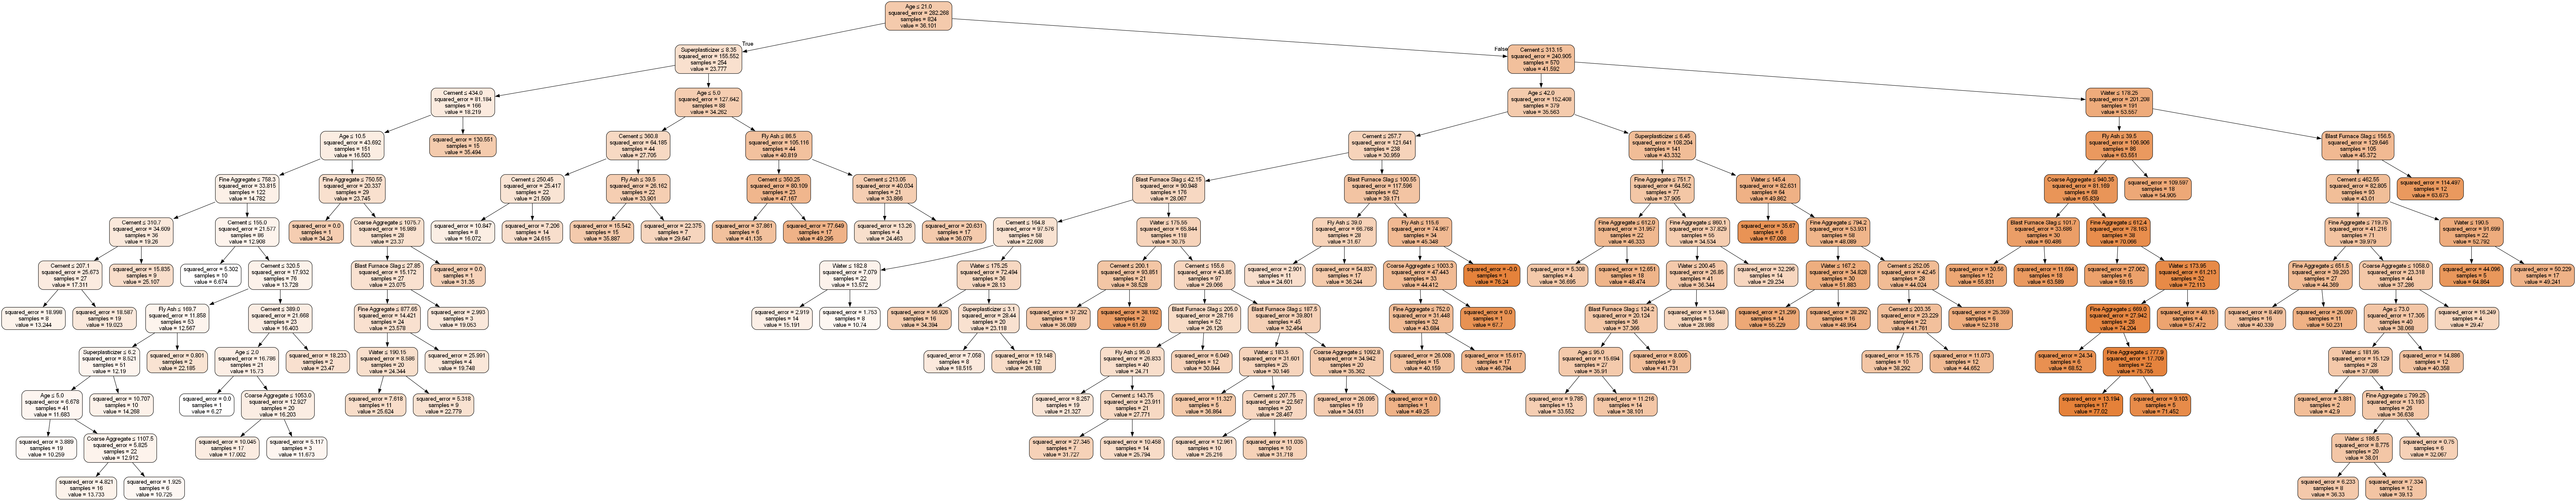

In [296]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props
dot_data = export_graphviz(tree_est, out_file='boston_tree.dot',feature_names=concrete_df.columns[0:-1],filled=True, 
                           rounded=True, special_characters=True)

with open('boston_tree.dot') as f:
    dot_graph = f.read()  

# create the source object in graphviz and render it as a png image
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into our jupyter nb
Image(I.render())

##### 3.4.1.2. Prediction and Evaluation

The trained decision tree model is used to generate predictions on the test set. Model performance is then evaluated by calculating the **R² score** and the **MSE** on the test data, providing insight into both the explained variance and prediction error.

In [297]:
y_pred = tree_est.predict(X_test)

print("R² Score on Test Set:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score on Test Set: 0.7656051074298786
Mean Squared Error: 61.73484305572844


##### 3.4.1.3 Feature Importance Plot

To further interpret the decision tree model, feature importance scores are computed to quantify each variable’s contribution to the prediction task. 

In [298]:
feature_importances = pd.Series(data=tree.feature_importances_, index=list(concrete_df.columns[0:-1]))
feature_importances.sort_values(axis=0, ascending=False)

Age                   0.354686
Cement                0.304908
Water                 0.109655
Superplasticizer      0.094740
Blast Furnace Slag    0.053427
Fine Aggregate        0.039896
Fly Ash               0.029759
Coarse Aggregate      0.012929
dtype: float64

| Feature                                                   | Importance | Meaning                                                                                                                                             |
| --------------------------------------------------------- | ---------- | --------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Age (day)**                                             | 0.355     | The age of concrete is the most important feature, contributing \~35,5% of the total split importance. It heavily influences the strength prediction. |
| **Cement (component 1)(kg in a m^3 mixture)**             | 0.305     | Cement amount is the second most influential feature, about 30,5% importance — a key material affecting strength.                                     |
| **Water (component 4)(kg in a m^3 mixture)**              | 0.110     | Water content also plays a significant role (\~11%), impacting the mixture's properties.                                                            |
| **Superplasticizer (component 5)(kg in a m^3 mixture)**   | 0.095     | Superplasticizer's role is noticeable (\~9.5%), affecting workability and strength.                                                                 |
| **Blast Furnace Slag (component 2)(kg in a m^3 mixture)** | 0.054     | Moderately important (\~5.4%), influencing the final properties.                                                                                    |
| **Fine Aggregate (component 7)(kg in a m^3 mixture)**     | 0.039     | Low importance (\~3.9%), minor influence on predictions.                                                                                            |
| **Fly Ash (component 3)(kg in a m^3 mixture)**            | 0.030     | Minimal contribution (\~3%).                                                                                                                      |
| **Coarse Aggregate (component 6)(kg in a m^3 mixture)**   | 0.013     | Smallest importance (\~1.3%), less relevant in this model.                                                                                          |


 The resulting table lists the features in descending order of importance and provides a brief interpretation of each variable’s role. Higher importance values indicate a greater influence on the model’s predictions. 

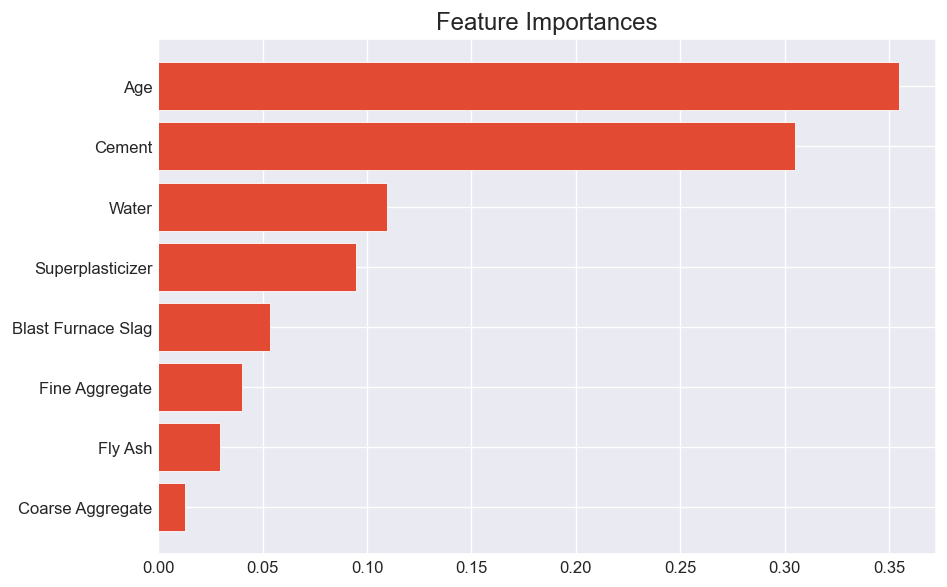

In [299]:
importances = tree_est.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), feature_names[indices])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
plt.close() 


In addition to the table, the feature importances are visualized in the bar chart above. This graphical representation provides a more intuitive comparison of the relative influence of each variable, clearly highlighting the dominant role of `Age` and `Cement` in the prediction task.

##### 3.4.1.4. Model Optimization

To further improve the model, hyperparameter tuning is conducted via `RandomizedSearchCV` on the `DecisionTreeRegressor`.

To optimize the tree-based model we need to do **Hyperparameter Tuning** for multiple **hyperparameters**. In order to do so efficiently, we perform a **Grid search cross-validation** across the space of potential **hyperparameter**-combinations.

In [300]:
# Define the model
tree = DecisionTreeRegressor(random_state=0)

# Define the hyperparameters grid to search
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'] 
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=kf,                # 10-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE as scoring metric
    n_jobs=-1,           # Use all CPU cores
    verbose=1            # Print progress
)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Best hyperparameters found
print("Best parameters:", grid_search.best_params_)

# Use the best estimator for prediction
best_tree = grid_search.best_estimator_

# Predict on test set
y_pred = best_tree.predict(X_test)

# Evaluate
mse_hyper = mean_squared_error(y_test, y_pred)
r2_hyper = r2_score(y_test, y_pred)
print(f"Test set MSE: {mse_hyper:.4f}")
print(f"Test set R²: {r2_hyper:.4f}")

y_train_pred = best_tree.predict(X_train)
train_mse_hyper = mean_squared_error(y_train, y_train_pred)
train_r2_hyper = r2_score(y_train, y_train_pred)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test set MSE: 57.6107
Test set R²: 0.7813


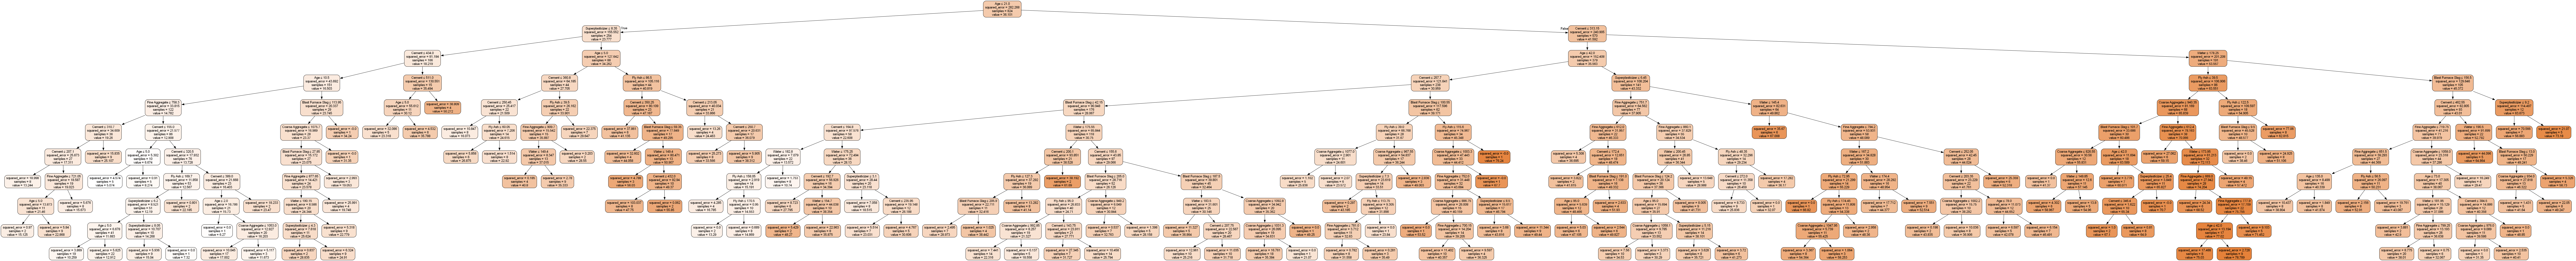

In [301]:
# Train the optimized tree
optimized_tree = DecisionTreeRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=0
)
optimized_tree.fit(X_train, y_train)

# Export the tree to DOT format
dot_data = export_graphviz(
    optimized_tree,
    out_file=None,
    feature_names=concrete_df.columns[:-1],
    filled=True,
    rounded=True,
    special_characters=True
)

# Render and display using graphviz
graph = graphviz.Source(dot_data, format='png')
Image(graph.render('optimized_tree'))


Our resulting decision tree consists of a fairly large amount of leafs. The recursive binary splitting that creates the splits within the tree under the hood tends to fit the regression tree model to the data very well, resulting in **low bias**. A complex tree with to many splits and depth (of exploration) can therefore lead to **overfitting**. 
To reduce **overfitting** and **lower variance** we tune the (regularization) **hyperparameter ccp_alpha**. Increasing this hyperparameter increases the **pruning** done to our decision tree, reducing it's depth and complexity and effectively reducing **overfitting**.
The increased pruning should **improve the generalization** of our tree-based model (lower variance on test sets) with a little **trade-off in increased bias**.
We have already got a strong performance (R² ≈ 0.7813), and **pruning** it can improve generalization further.

In [302]:
# Fit a full tree
path = DecisionTreeRegressor(random_state=0).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Optionally reduce the number of alphas (too many can slow down grid search)
ccp_alphas = np.unique(np.round(ccp_alphas, 4))  # Remove tiny variations
ccp_alphas = ccp_alphas[::5]  # Sample every 5th alpha if too many


In [303]:
# Define the parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': ccp_alphas  # ← added
}

tree = DecisionTreeRegressor(random_state=0)
grid = GridSearchCV(tree, param_grid, cv=kf, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


Fitting 10 folds for each of 5670 candidates, totalling 56700 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.0000e+00, 5.0000e-04, 1.0000e-03, 1.5000e-03, 2.0000e-03,
       2.6000e-03, 3.1000e-03, 3.6000e-03, 4.1000e-03, 4.6000e-03,
       5.1000e-03, 5.9000e-03, 6.8000e-03, 7.4000e-03, 8.4000e-03,
       9.0000e-03, 9.9000e-03, 1.0700e-02,...
       1.4540e-01, 1.5880e-01, 1.7200e-01, 1.9110e-01, 2.2550e-01,
       2.3560e-01, 2.6780e-01, 2.9830e-01, 3.2700e-01, 3.6670e-01,
       4.6210e-01, 5.2590e-01, 5.8120e-01, 7.7410e-01, 1.0988e+00,
       1.2426e+00, 1.8754e+00, 2.3621e+00, 4.5914e+00, 1.6451e+01]),
                         'max_depth': [5, 10, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='r2', verbose=1)

In [304]:
#Evaluate and visualize
print("Best parameters:", grid.best_params_)

best_tree = grid.best_estimator_
y_pred = best_tree.predict(X_test)

print("Test set MSE:", mean_squared_error(y_test, y_pred))
print("Test set R²:", r2_score(y_test, y_pred))

Best parameters: {'ccp_alpha': np.float64(0.001), 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test set MSE: 57.82742408904905
Test set R²: 0.7804407983231801


The optimal hyperparameters after pruning were determined to be:  
`ccp_alpha = 0.001`, `max_depth = None`, `max_features = None`, `min_samples_leaf = 1`, and `min_samples_split = 2`.  
The pruning parameter `ccp_alpha = 0.001` indicates a very light level of pruning, which means only a small portion of the tree structure was affected.

When comparing performance before and after pruning on the test set, the results show a slight decline. The **Mean Squared Error (MSE)** increased from **57.6107** to **57.8274**, reflecting a slight deterioration in prediction accuracy. Simultaneously, the **R² score** dropped marginally from **0.7813** to **0.7804**, indicating the model was able to explain slightly less variance in the test data after pruning.

These findings suggest that the original, unpruned decision tree was already well-generalized. Therefore, the pruning applied—although mild—may have inadvertently removed useful splits rather than reducing overfitting. As a result, pruning did not lead to any improvement in the model's performance and instead introduced a small loss in predictive power.

We plot the pruned tree for comparison.

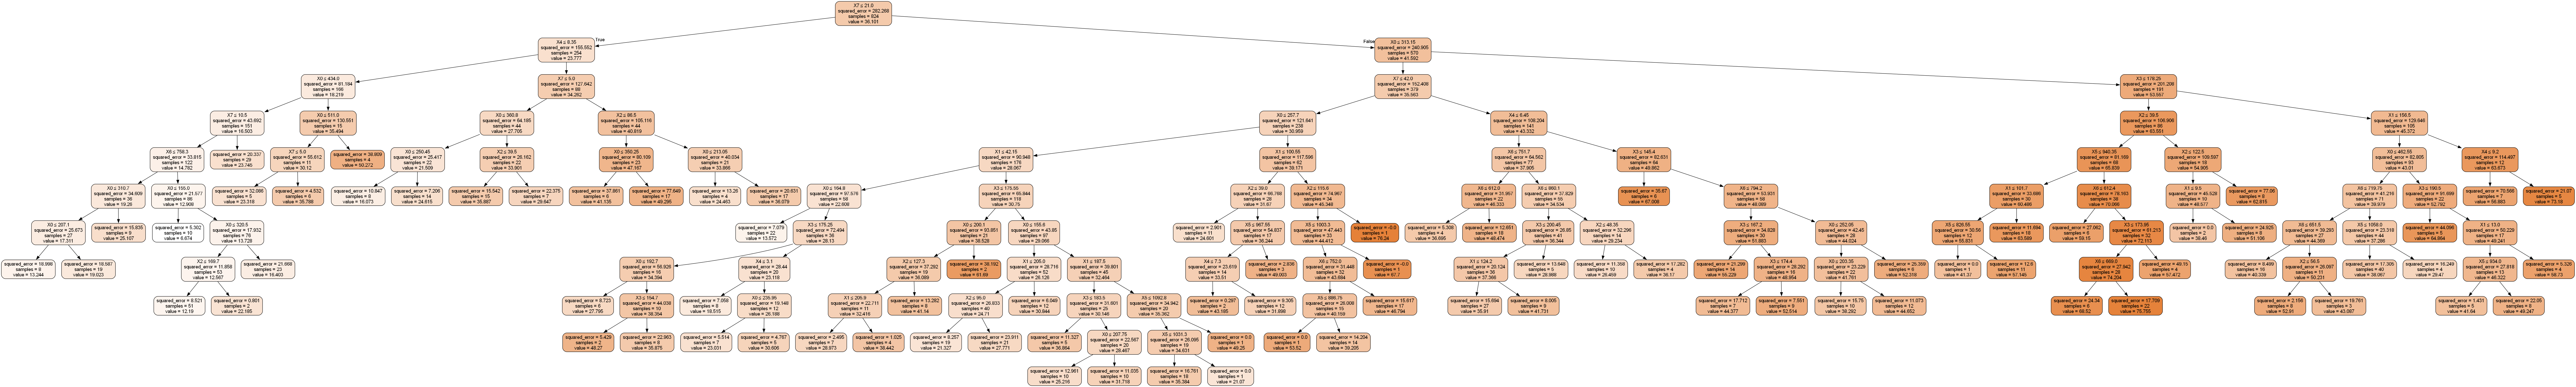

In [305]:
# Fit the optimized and pruned tree
final_tree = DecisionTreeRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=10,
    ccp_alpha=0.2008,
    random_state=0
)
final_tree.fit(X_train, y_train)

# Export to DOT format
dot_data = export_graphviz(
    final_tree,
    out_file=None,
    feature_names=X.columns if hasattr(X, 'columns') else [f"X{i}" for i in range(X.shape[1])],
    filled=True,
    rounded=True,
    special_characters=True
)

# Render with graphviz
tree_graph = graphviz.Source(dot_data, format="png")
tree_graph.render("final_pruned_tree", cleanup=True)
Image("final_pruned_tree.png")


##### 3.4.1.5. Model Evaluation & Diagonistic Checking

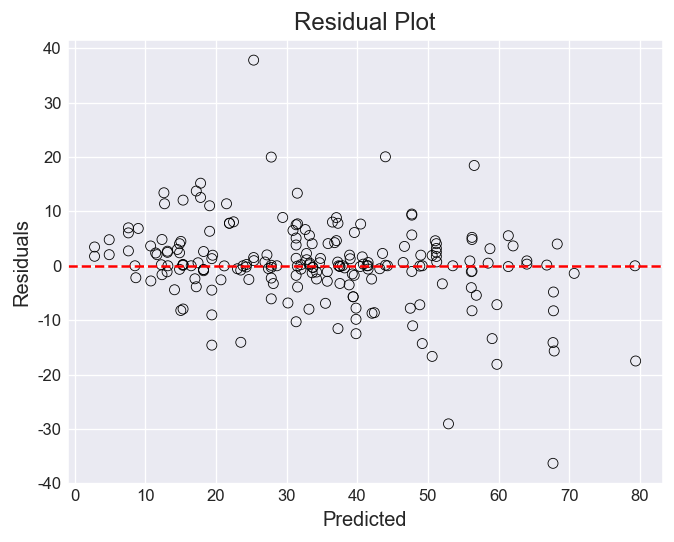

In [306]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, edgecolor='k', facecolor='none')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


The parity plot checks how close predictions are to actual values:

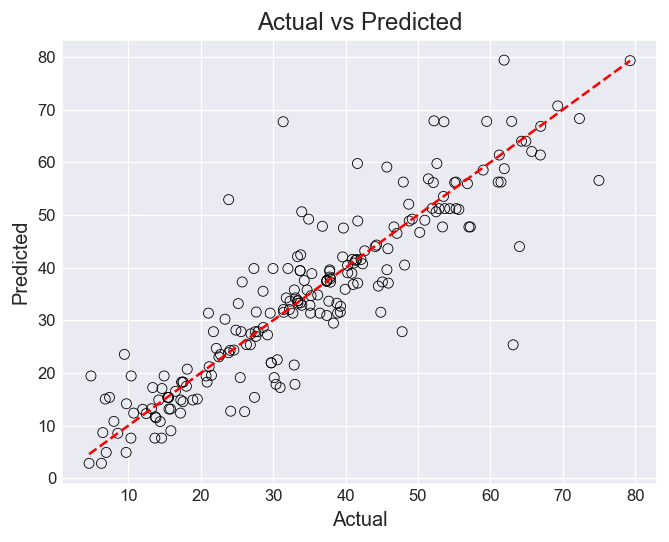

In [307]:
plt.scatter(y_test, y_pred, edgecolor='k', facecolor='none')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()


We perform a quick intermediate model complexity check to check if the tree is too deep or has too many leaves. A very large tree usually overfits.

In [308]:

print("Tree depth:", final_tree.get_depth())
print("Number of leaves:", final_tree.get_n_leaves())

Tree depth: 10
Number of leaves: 83


We then check for **overfitting** via **R²** and **MSE** on the training and test-set.

In [309]:
# Predictions
y_train_pred = final_tree.predict(X_train)
y_test_pred = final_tree.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")


Train R²: 0.9400
Test R²: 0.7794
Train MSE: 16.9480
Test MSE: 58.1049


Interpretation:

The model fits the training data very well but is less accurate on new data, indicating some degree of overfitting, but not severe.

The gap between train and test metrics has reduced compared to the previous attempts, so this model generalizes better.

| Model # | Model Name                        | Test R² | Test MSE |
|---------|----------------------------------|---------|----------|
| 1       | Decision Tree - Basic             | 0.7656  | 61.7348  |
| 2       | Decision Tree - Hyperparameter Tuned | **0.7813**  | **57.6107**  |
| 3       | Decision Tree - With Pruning      | 0.7804  | 57.8274  |
| 4       | Decision Tree - Final Pruned      | 0.7794  | 58.1049  |


**Note:** Model 2 shows the best overall performance with the highest Test R² and lowest Test MSE. We plan to append this model’s results to `model_results_df` for further comparison with other models.

In [310]:
model_name = "Decision Tree - Hyperparameter Tuned"

# append the result to Dataframe
model_results_df = record_model_results(
    model_results_df,
    model_name,
    train_r2_hyper,
    train_mse_hyper,
    r2_hyper,
    mse_hyper
)

#### 3.4.2. Bagging and Random Forests

##### 3.4.2.1. Bagging

To determine an efficient ensemble size for the Random Forest model, different values of `n_estimators` were evaluated using **the out-of-bag (OOB) score** — a built-in validation method where each tree is evaluated on data not used during its own training.

In [311]:
for n in [50, 100, 200, 300, 500]:
    model = RandomForestRegressor(n_estimators=n, random_state=0, oob_score=True)
    model.fit(X_train, y_train)
    print(f"{n} trees - OOB Score: {model.oob_score_:.4f}")

50 trees - OOB Score: 0.9062
100 trees - OOB Score: 0.9118
200 trees - OOB Score: 0.9126
300 trees - OOB Score: 0.9120
500 trees - OOB Score: 0.9122


Based on the results, the **OOB score** obtained with 200 trees was the highest among all tested values, suggesting that this configuration offers a favorable trade-off between performance and computational efficiency. Therefore, a bagged ensemble model was constructed using 200 estimators.

In [312]:
bagger = RandomForestRegressor(
    n_estimators=200,
    criterion='squared_error',         
    bootstrap=True,
    oob_score=True,
    random_state=0
)

bag_est = bagger.fit(X_train, y_train)

To assess the predictive performance of the final bagged ensemble model, the **test set R²** and **MSE** are first computed. 

In [313]:
# compute the test MSE
y_pred = bag_est.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print(f"Test R² = {test_r2:.4f}")
print(f"Test MSE = {test_mse:.4f}")

Test R² = 0.9241
Test MSE = 19.9774


With a high **R²** value and a low **test MSE** of 19.97, the model demonstrates strong generalization capabilities and accurate predictions on unseen data. To further support this evaluation, a scatter plot is generated comparing predicted and actual values.

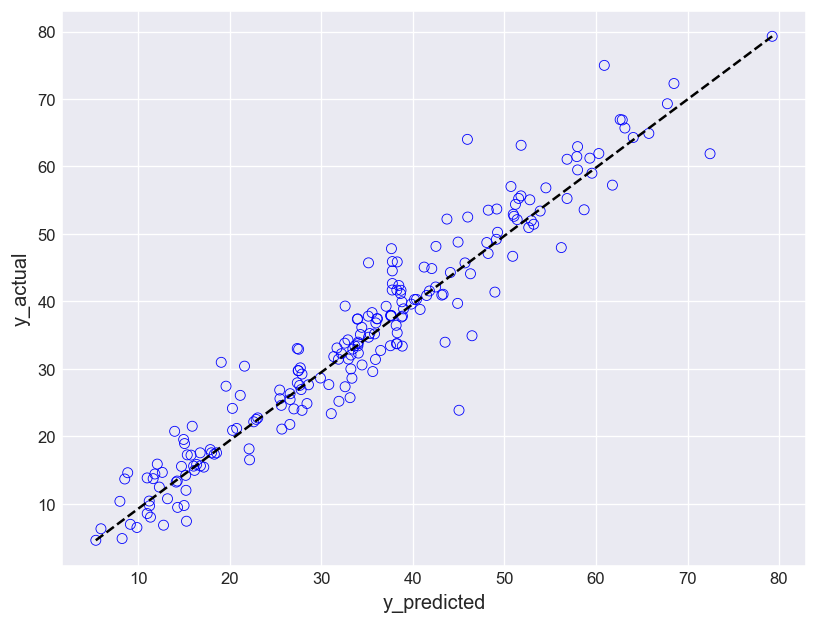

In [314]:
# visualize the test MSE
# Plot the predicted vs the actual medv response
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(y_pred, y_test, facecolor='None', edgecolor='b')
# add a reference unity line
ax.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], linestyle='--', color='k');
ax.set_xlabel('y_predicted')
ax.set_ylabel('y_actual')

plt.show()

Most points lie close to the diagonal reference line, visually confirming the model's strong predictive power.

##### 3.4.2.2 Random forest

To further evaluate the model performance, a random forest regressor with 200 trees was trained using the same training data.

In [315]:
# build a random forest and fit it to the training data
forest = RandomForestRegressor(n_estimators=200, criterion='squared_error', max_features=4, bootstrap=True, 
                               oob_score=True, random_state=0 )

forest_est = forest.fit(X_train, y_train)

Subsequently, the test R² and test MSE are computed to evaluate the model’s generalization performance on unseen data.

In [316]:
# Compute the test MSE of the random forest
y_train_pred = forest_est.predict(X_train)
train_mse_basic = mean_squared_error(y_train, y_train_pred)
train_r2_basic = r2_score(y_train, y_train_pred)

y_pred = forest_est.predict(X_test)
test_mse_basic = mean_squared_error(y_test, y_pred)
test_r2_basic = r2_score(y_test, y_pred)

print(f"Test R² = {test_r2_basic:.4f}")
print(f"Test MSE = {test_mse_basic:.4f}")

Test R² = 0.9245
Test MSE = 19.8936


##### 3.4.2.3. Comparison of the results

Interpretation: 

| Model         | Description                              | Test MSE    |
| ------------- | ---------------------------------------- | ----------- |
| Bagging       | Uses all features, averages many trees   | 19.97       |
| Random Forest | Random subset of features for each split | **19.89**  |


Random Forest introduces feature randomness (via max_features) to decorrelate trees more than standard bagging. So in this case, both the test MSE and test R² show slight improvements compared to Bagging, indicating that Random Forest offers a marginal but consistent performance advantage.

##### 3.4.2.4. Model Refinement

**Feature importance values** derived from the trained random forest model are computed and sorted to quantify the relative contribution of each input variable to the prediction task.

In [317]:
# Examine the feature importances
feature_importances = pd.Series(data=forest_est.feature_importances_, index=list(concrete_df.columns[0:-1]))
feature_importances = feature_importances.sort_values(axis=0, ascending=False)
feature_importances


Age                   0.338443
Cement                0.243046
Water                 0.126728
Superplasticizer      0.084784
Blast Furnace Slag    0.066258
Fine Aggregate        0.056144
Coarse Aggregate      0.045906
Fly Ash               0.038691
dtype: float64

To enhance interpretability, the results are visualized in a horizontal bar chart, offering a clear comparison of each variable’s predictive influence.

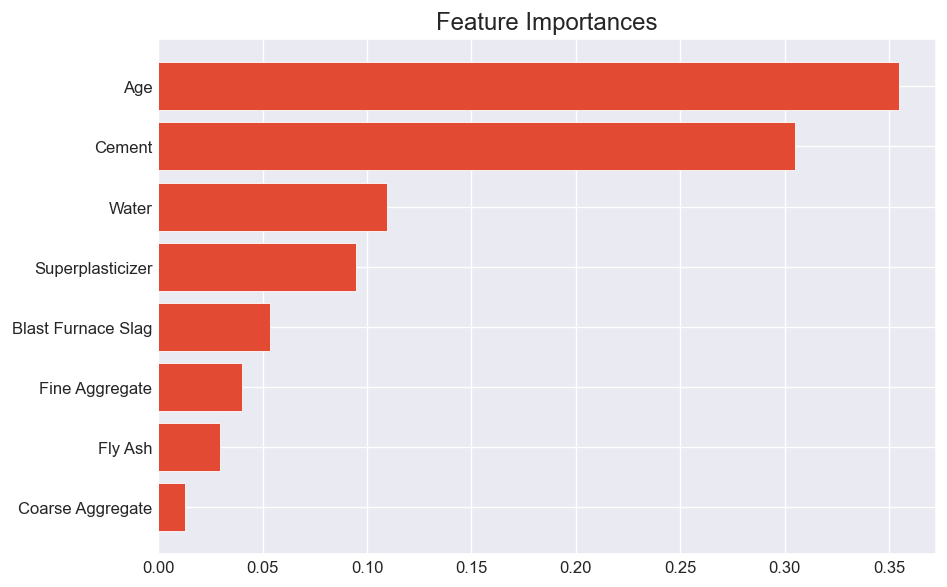

In [318]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
plt.barh(range(len(importances)), importances[indices][::-1], align='center')
plt.yticks(range(len(importances)), np.array(feature_names)[indices][::-1])
plt.tight_layout()
plt.show()
plt.close()

After fitting the Random Forest model, the feature importance analysis reveals which input variables most strongly influence the prediction. The feature `Age` is the most important, indicating it has the greatest impact on the concrete strength. `Cement content` follows as the second most influential feature. Other components like `Water`, `Superplasticizer`, and `Blast Furnace Slag` contribute moderately, while features such as `Fly Ash` have relatively low importance.

This insight helps to understand the key factors driving the model’s predictions, supports domain knowledge validation, and can guide feature selection or further data collection efforts.

In [319]:
# Feature selection
# List of all feature names in order, matching X_train columns
feature_names = concrete_df.columns[:-1].tolist()

# Top features to keep
top_features = [
    'Age', 
    'Cement', 
    'Water', 
    'Superplasticizer', 
    'Blast Furnace Slag'
]

# Get their column indices
top_indices = [feature_names.index(f) for f in top_features]

# Select columns by index
X_train_reduced = X_train[:, top_indices]
X_test_reduced = X_test[:, top_indices]

# Train the model on reduced features
model_reduced = RandomForestRegressor(random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# Predict and evaluate
y_pred_reduced = model_reduced.predict(X_test_reduced)
print("Test R²:", r2_score(y_test, y_pred_reduced))
print("Test MSE:", mean_squared_error(y_test, y_pred_reduced))


Test R²: 0.9204218667272444
Test MSE: 20.95926030807912


To enhance model efficiency, the **five most important features** — identified via feature importance analysis — are selected. A **Random Forest** is then trained on this reduced feature set, yielding comparable performance, which suggests that excluding less relevant features can maintain accuracy while reducing complexity and noise.

##### 3.4.2.5. Model Optimization

This section performs hyperparameter tuning for the random forest model using `GridSearchCV`, identifying the optimal combination of `max_depth` and `max_features`.

In [320]:
# Hyperparameter Tuning for Random Forest using GridSearchCV
# Define the model
rf = RandomForestRegressor(n_estimators=200, random_state=0)

# Define the parameter grid to search
param_grid = {
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=kf, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_


Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best parameters: {'max_depth': 20, 'max_features': 'log2'}


In [321]:
y_pred = best_rf.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))

Test R²: 0.9227968731428817
Test MSE: 20.3337319669193


The **test R²** improved slightly to ~0.9228 (from 0.9204 before) and the **test MSE** decreased to ~20.3337 (from 20.95 before).

This means the model’s performance got a bit better — more accurate and slightly more robust.

##### 3.4.2.6. Model evaluation and diagnostic checking

To achieve model evaluation and diagnostic checking, **residual analysis** is first conducted. This involves computing the residuals by subtracting predicted values from the true values, and then visualizing them against the **predicted values** in a scatter plot. 

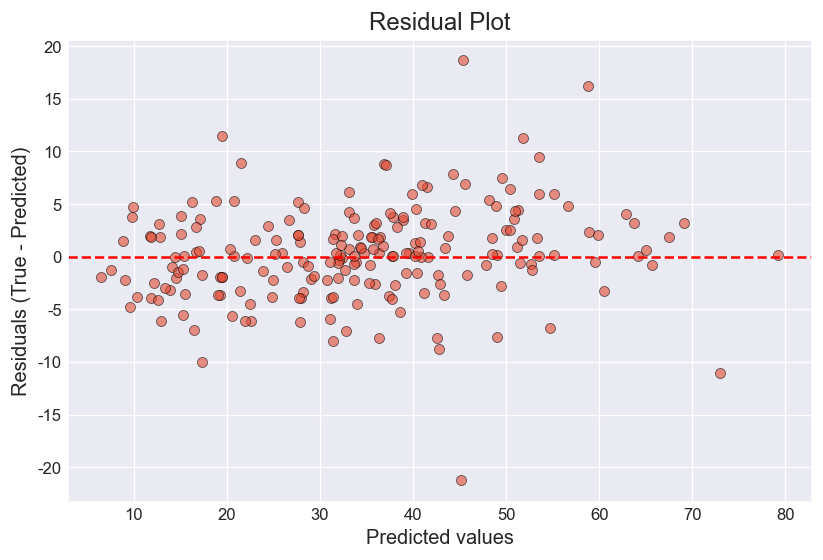

In [322]:
#Residual analysis
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot')
plt.show()

This residual plot shows the difference between the true and predicted values (residuals) across the range of predicted values. The **red dashed line** represents the ideal case where **residuals = 0**.
Most points are randomly scattered around this line, indicating that the model errors are approximately unbiased. There is no apparent curve or funnel-shaped pattern, which suggests no major **non-linearity** in the data and no evidence of **heteroscedasticity** (i.e., constant variance of residuals).
A few **outliers** (e.g., residuals **below -15** and **above 15**) may indicate potential extreme cases or **noisy data points**, which can be further investigated.

**Conclusion**: The residuals appear to be randomly and symmetrically distributed around zero, supporting the assumption of linearity and homoscedasticity in the model. This implies that the model is reasonably well-fitted.


To further assess the model’s generalization capability, the **OOB-score** is computed.

In [323]:
# Re-train model with OOB enabled
rf_oob = RandomForestRegressor(n_estimators=200, max_depth=best_rf.max_depth,
                               max_features=best_rf.max_features,
                               random_state=0, oob_score=True)
rf_oob.fit(X_train, y_train)

print(f"OOB R² score: {rf_oob.oob_score_:.4f}")

OOB R² score: 0.9112


**OOB score** being close to the **test R²** (~0.92) confirms the train-test split results are reliable and **not overfitting**.

| Model # | Model Name                  | Test R²   | Test MSE   |
|---------|-----------------------------|-----------|------------|
| 1       | RF Basic (n_estimators=200) | **0.9245** | **19.8936** |
| 2       | RF Reduced Features (Top 5) | 0.9204    | 20.9593    |
| 3       | RF with GridSearchCV Tuning | 0.9228    | 20.3337    |

**Analysis:**

- The basic Random Forest model (Model 1) with 200 trees surprisingly outperforms the tuned and reduced-feature models.
- Possible reasons include:
  - **Sufficient complexity:** The basic model already captures the underlying patterns well without overfitting.
  - **Feature reduction may lose useful information:** Removing features (Model 2) reduces the input space, potentially discarding relevant data, leading to slightly worse performance.
  - **GridSearchCV tuning might not explore the optimal parameter space fully:** The parameter grid may be limited or the best parameters may not generalize better than the default ones.
  - **Random variation:** Due to randomness in training and limited test data, small differences in metrics are expected.
- In practice, a simpler default model can perform well if the data is clean and the signal strong. Further tuning with broader parameter search or ensemble methods might improve results beyond the baseline.


In [324]:
# append basic RF model to do further Model Comparison
model_name = "Random Forest Basic"

# append the result to Dataframe
model_results_df = record_model_results(
    model_results_df,
    model_name,
    train_r2_basic,
    train_mse_basic,
    test_r2_basic,
    test_mse_basic
)

#### 3.4.3. Gradient Boosting Model

##### 3.4.3.1. Model training

A Gradient Boosting Regressor is instantiated with specified hyperparameters and then trained on the full training dataset.

In [325]:
# creating and training a Gradient Boosting Regressor model on the traning data
booster = GradientBoostingRegressor(
    loss='squared_error',        
    learning_rate=0.01,          
    n_estimators=200,            
    max_depth=3,                 
    random_state=0
)

boost_est = booster.fit(X_train, y_train)

The trained model is used to predict target values on the test set, and its performance is assessed using MSE and R² score.

In [326]:
# Make predictions on the test set and evaluate model performance
y_pred = boost_est.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test MSE:", mse)

Test MSE: 58.88640348290601


##### 3.4.3.2. Feature importance plot

Feature importances from the Gradient Boosting model are extracted and sorted in descending order to identify the most influential predictors.

In [327]:
feature_importances = pd.Series(data=boost_est.feature_importances_, index=list(concrete_df.columns[:-1]))
sorted_feature_importances = feature_importances.sort_values(ascending=False)
sorted_feature_importances


Age                   0.396281
Cement                0.305334
Superplasticizer      0.112782
Water                 0.088723
Blast Furnace Slag    0.059639
Fine Aggregate        0.026854
Fly Ash               0.007686
Coarse Aggregate      0.002701
dtype: float64

The Gradient Boosting model identifies **"Age"** and **"Cement"** as the most influential factors in predicting the target variable, indicating these features have the strongest impact on the model’s predictions. Other features like **"Superplasticizer"** and **"Water"** also contribute notably but to a lesser degree. Features such as **"Coarse Aggregate"** and **"Fly Ash"** show minimal influence, suggesting they play a minor role in the prediction.

##### 3.4.3.3. Partial dependence plots

We produce **partial dependence plots** for the three most important features — Superplasticizer, Cement, and Age — to provide insight into how changes in each individual variable affect the model’s predicted outcome.

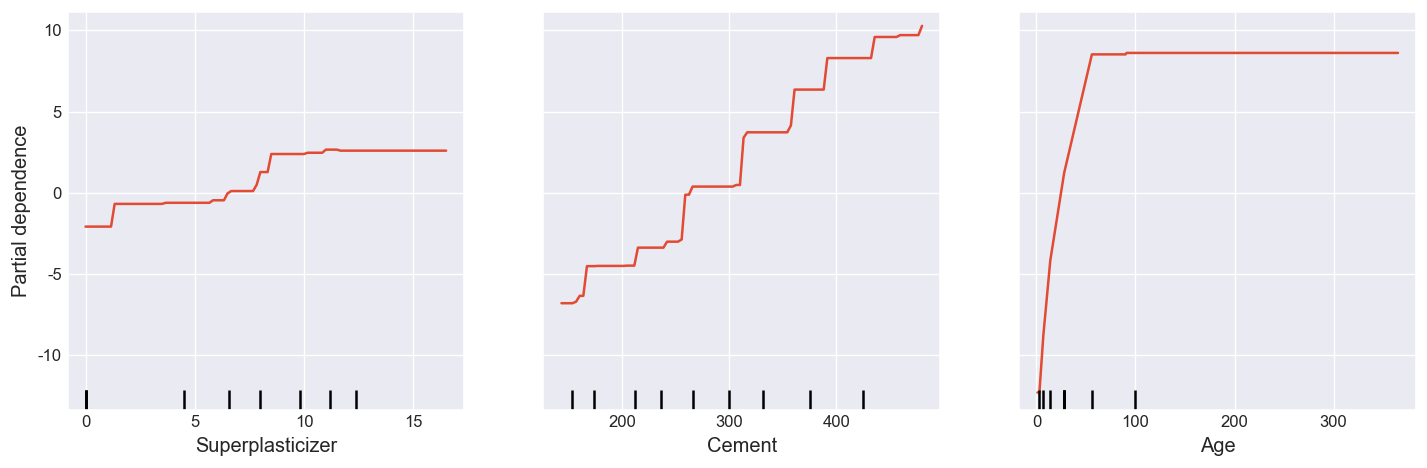

In [328]:
feature_idxs = np.argsort(feature_importances.values)[-3:]

# Plot PDP
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    boost_est,                  
    X_train,                    
    features=feature_idxs,      
    feature_names=feature_importances.index.tolist(),
    ax=ax
)
plt.tight_layout()
plt.show()

There might be an optimal range for **superplasticizer** where its positive effect on the predicted outcome is most pronounced, and further increases might not be beneficial. For **Cement**, the "steps" could suggest that the model has specific "regimes" or **thresholds** for cement content where the properties change significantly. Higher cement content generally leads to a better (higher) predicted outcome, but these improvements might not be linear. The plot of **Age**  implies that the **most significant improvements** in the predicted outcome due to aging occur within the first couple of months. Beyond this initial period, further aging has a negligible additional impact on the predicted outcome. This could indicate a **saturation point** where the cement's properties stabilize.

##### 3.4.3.4. Model refinement

As a first step in model refinement, **feature selection** is performed by retaining only the most important features based on the **feature importances** derived from the gradient boosting model. Subsequently, the model is re-trained using only the selected features, and the **test MSE** is computed to evaluate its performance.

In [329]:
important_features = [
    'Age',
    'Cement',
    'Superplasticizer',
    'Water',
    'Blast Furnace Slag'
]

X_selected = concrete_df[important_features]
y = concrete_df['Concrete compressive strength'] 

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected, y, test_size=0.2, random_state=0)

booster_sel = GradientBoostingRegressor(
    loss='squared_error',       
    learning_rate=0.001,
    n_estimators=5000,
    max_depth=4,
    random_state=0
)

boost_est_sel = booster_sel.fit(X_train_sel, y_train_sel)

y_pred_sel = boost_est_sel.predict(X_test_sel)
mse_sel = mean_squared_error(y_test_sel, y_pred_sel)
r2_sel = r2_score(y_test_sel, y_pred_sel)
print("Test MSE with selected features:", mse_sel)


Test MSE with selected features: 27.248453288441535


In the second step, **feature selection** is refined by focusing exclusively on the three variables with the most distinct patterns in the partial dependence plots. The resulting **test MSE** is subsequently calculated.

In [330]:
# Select features strongly supported by PDP interpretation
important_features_pdp = [
    'Age',
    'Cement',
    'Superplasticizer'
]

X_selected_pdp = concrete_df[important_features_pdp]
y = concrete_df['Concrete compressive strength']


# Set up the gradient boosting regressor with early stopping
booster_sel = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.01,      
    n_estimators=1000,       
    max_depth=4,
    random_state=0,
    validation_fraction=0.1, 
    n_iter_no_change=50,  
    tol=1e-4
)

# Fit model with early stopping
boost_est_sel = booster_sel.fit(X_train_sel, y_train_sel)

# Predictions and evaluation
y_pred_sel = boost_est_sel.predict(X_test_sel)
mse_sel = mean_squared_error(y_test_sel, y_pred_sel)
r2_sel = r2_score(y_test_sel, y_pred_sel)

print("Test MSE with PDP-based selected features:", mse_sel)


Test MSE with PDP-based selected features: 27.119307187544667


The dropped features might still contain some useful information, even if their importance seemed low, as indicated by the slightly better performance (lower **test MSE**) when using all selected features (**27.25**) compared to using only the PDP-based subset (**27.12**).

##### 3.4.3.5. Model optimization

To further improve the model, hyperparameter tuning is conducted via `RandomizedSearchCV` on the `GradientBoostingRegressor`.

In [331]:
# Define the model
gbr = GradientBoostingRegressor(random_state=0)

# Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=50,           # number of parameter settings sampled
    cv=kf,                # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # minimize MSE
    n_jobs=-1,           # use all cores
    random_state=0,
    verbose=1
)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best model
best_booster = random_search.best_estimator_

# Predict on test data
y_pred = best_booster.predict(X_test)

# Calculate MSE and R2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best parameters: {random_search.best_params_}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R2 score: {r2:.4f}")


Fitting 10 folds for each of 50 candidates, totalling 500 fits


Best parameters: {'subsample': 0.6, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.1}
Test MSE: 17.3755
Test R2 score: 0.9340


The **Gradient Boosting** model uses carefully chosen **hyperparameters** to balance accuracy and generalization. It builds 500 trees with a maximum depth of 4, limiting complexity to **avoid overfitting**. Each tree is trained on 60% of the data and considers only a subset of features at each split, adding randomness to improve robustness. Minimum samples per split and leaf prevent overly specific rules, while a learning rate of 0.1 ensures gradual, stable learning. Overall, these settings help the model perform well on unseen data while avoiding **overfitting**. The tuned Gradient Boosting model shows strong predictive performance, achieving a low test MSE of 17.3755 and a high R² of 0.934.

##### 3.4.3.6. Model evaluation and diagnostic checking

To evaluate the model and perform diagnostic checking, **residual analysis** is first conducted to examine whether the errors are randomly distributed and free of systematic bias.

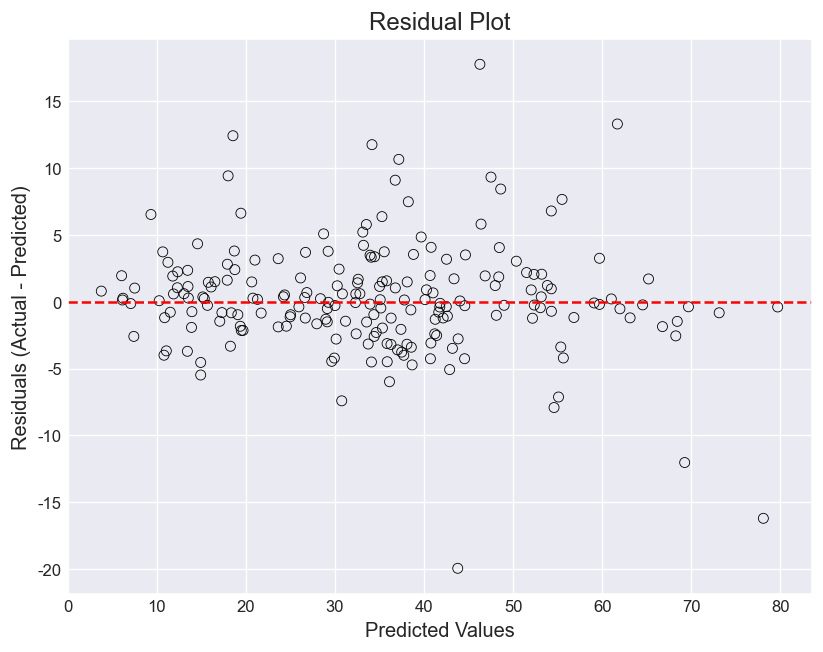

In [332]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, edgecolor='k', facecolor='none')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()

The residual plot shows that the residuals are evenly scattered around zero without any clear pattern, indicating that the model's errors are randomly distributed. The consistent spread of residuals suggests that the assumption of constant variance is met, and although there are a few isolated outliers, they do not undermine the overall fit. This implies that the model captures the data well, with no strong bias or missed nonlinear relationships.

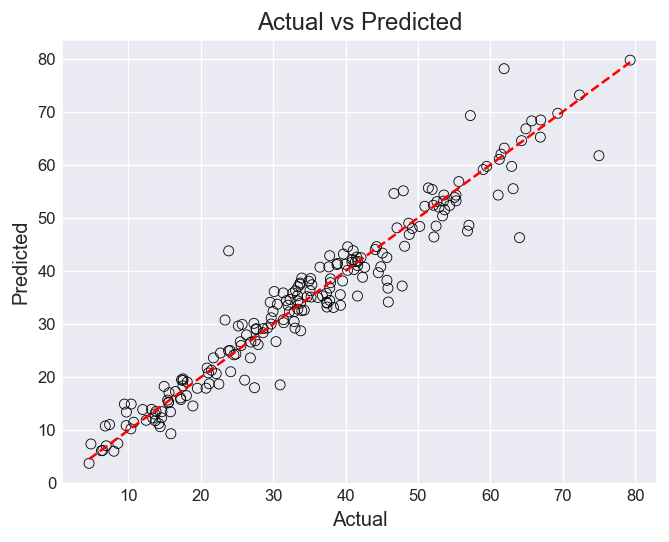

In [333]:
plt.scatter(y_test, y_pred, edgecolor='k', facecolor='none')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()
plt.close()

This scatter plot shows the relationship between the actual values (x-axis) and the predicted values (y-axis) on the test set. The **red dashed line** represents the ideal prediction line where `Predicted = Actual`.
Most points lie very close to this line, indicating that the model is performing well and making accurate predictions. A few outliers can be observed, especially at higher value ranges, suggesting that the model may slightly struggle with **extreme values**. There is no apparent systematic bias (e.g., consistently over- or under-predicting).

**Conclusion**: The model demonstrates strong predictive power with high alignment between actual and predicted values. This plot supports the reliability of the model in generalizing to unseen data.


A comparison between **training and testing performance** is then performed by calculating the R² and MSE for both sets.

In [334]:
# Predictions
y_train_pred = best_booster.predict(X_train)
y_test_pred = best_booster.predict(X_test)

# R²
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Train R²: {r2_train:.3f}, Test R²: {r2_test:.3f}")
print(f"Train MSE: {mse_train:.3f}, Test RMSE: {mse_test:.3f}")


Train R²: 0.992, Test R²: 0.934
Train MSE: 2.195, Test RMSE: 17.375


The **gradient boosting model** shows excellent fit on training data and still performs very well on test data. The performance drop is moderate and expected in real-world modeling. There is no strong evidence of overfitting.

Subsequently, a comparative summary of different GBR models is provided below, highlighting their respective **test R²** and **MSE** values.

| Model # | Model Name                   | Test R² | Test MSE |
|---------|------------------------------|---------|----------|
| 1   | GBR Basic                    | 0.7764  | 58.8864  |
| 2   | GBR with Top-5 Features      | 0.8965  | 27.2485  |
| 3   | GBR with PDP-based Features  | 0.8970  | 27.1193  |
| 4   | GBR Best booster             | **0.9340**  | **17.3755**  |

Based on the comparison table, **Model 4 (GBR Best booster)** achieved the **highest R² score (0.9340)** and the **lowest Test MSE (17.3755)** among all tested GBR variants. This indicates that it offers the best generalization performance and predictive accuracy on unseen data.

Given its superior performance, we selected **GBR Best booster** as the final Gradient Boosting model and included it in `model_results_df` for a comprehensive comparison against other models in our project. This ensures a consistent and fair evaluation across all candidate algorithms.

In [335]:
model_name = "Gradient Boosting - Best Booster"

# append the result to Dataframe
model_results_df = record_model_results(
    model_results_df,
    model_name,
    r2_train,
    mse_train,
    r2_test,
    mse_test
)

## 4. Discussion

In this chapter, we evaluate and compare the performance of various regression models applied to the **concrete compressive strength prediction task**. The analysis begins with a summary table that displays key metrics for each model, such as training and testing **R²** scores, **MSE**, and their differences. This table is sorted by the **test R²** score to highlight the most generalizable models.

Following the table, three types of visualizations are used to provide deeper insights into each model’s behavior:

- A horizontal bar chart compares Test R² and normalized Test MSE across models.
- A scatter plot shows the relationship between Training and Testing R², illustrating generalization vs. overfitting.
- Another scatter plot compares Train vs. Test MSE to assess error consistency.

These visual tools help uncover trade-offs between model complexity, accuracy, and generalization capability, serving as a foundation for selecting and refining the best-performing models.

### 4.1 Model Performance Summary Table

This table presents all the models and their corresponding evaluation metrics that were previously stored in `model_results_df`. The models are sorted in descending order based on their **Test R²** scores, highlighting the best-performing models at the top. This summary allows for a quick comparison of model generalization performance on the test dataset.

In [336]:
# sort model results by Test R²
model_results_df = model_results_df.sort_values(by="Test_R2", ascending=False)
model_results_df

Model        R2         MSE   Test_R2  \
6      Gradient Boosting - Best Booster  0.992222    2.195383  0.934029   
5                   Random Forest Basic  0.985018    4.229069  0.924468   
3                  Lasso (alpha=0.0102)  0.923934   21.471063  0.840162   
2                  Ridge (alpha=0.9103)  0.928251   20.252556  0.828407   
1     Polynomial Regression (degree: 3)  0.932118   19.161017  0.805898   
4  Decision Tree - Hyperparameter Tuned  0.995620    1.236344  0.781263   
0               Basic Linear Regression  0.609124  110.332044  0.636961   

    Test_MSE    R2_Gap  
6  17.375482  0.058194  
5  19.893587  0.060550  
3  42.098124  0.083772  
2  45.194079  0.099844  
1  51.122475  0.126220  
4  57.610747  0.214356  
0  95.617174 -0.027837

### Summary Table (Ranked by Test R²)

| Model                                | Test R²  | Test MSE | R² Gap   |
|--------------------------------------|----------|----------|----------|
| Gradient Boosting - Best Booster     | 0.934029 | 17.375   | 0.058194 |
| Random Forest Basic                  | 0.924468 | 19.894   | 0.060550 |
| Lasso (alpha=0.0102)                 | 0.840162 | 42.098   | 0.083772 |
| Ridge (alpha=0.9103)                 | 0.828407 | 45.194   | 0.099844 |
| Polynomial Regression (degree: 3)    | 0.805898 | 51.122   | 0.126220 |
| Decision Tree - Hyperparameter Tuned| 0.781263 | 57.611   | 0.214356 |
| Basic Linear Regression              | 0.636961 | 95.617   | -0.027837|

In [337]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.unicode_minus'] = False  

# create ShortName by extracting a simplified model name from the 'Model' column
if 'ShortName' not in model_results_df.columns:
    model_results_df['ShortName'] = model_results_df['Model'].apply(
        lambda x: x.split('-')[0].strip() if '-' in x else x.split('(')[0].strip()
    )

### 4.2 Visual Analysis of Model Performance

#### 4.2.1 Horizontal Bar Plot of Test R² and Normalized Test MSE

The plot below presents a comparison of multiple regression models presented in this notebook using two key performance metrics.

The first metric, **Test R² (Coefficient of Determination)**, evaluates how well each model's predictions align with the actual data. A higher **R²** value, closer to 1, indicates that the model accounts for a greater proportion of the variance in the target variable, which reflects **stronger explanatory power**.

The second metric, **Normalized Test MSE (Mean Squared Error)**, measures the average squared difference between the predicted values and the actual outcomes. **Lower MSE** values signify better predictive accuracy. To make the **MSE** values **directly comparable with R² scores** in the same plot, each model’s **Test MSE** is normalized by dividing it by **the maximum MSE observed across all models**. This normalization scales the **MSE scores** to a range between 0 and 1, where a value of 1 corresponds to the worst-performing model in terms of MSE.

In this horizontal bar plot, each model is displayed along the vertical axis. For every model, two corresponding horizontal bars illustrate its performance on the test set.

The blue bar represents the **Test R²** score. A longer blue bar indicates a **higher R²** value, meaning the model explains a larger portion of the variance in the target variable, which reflects better overall performance. The orange bar shows the normalized Test MSE. Since MSE measures prediction error, a shorter orange bar indicates lower error and thus better predictive accuracy.

A well-performing model in this plot is characterized by a long blue bar combined with a short orange bar. This combination signifies both high explanatory power and low prediction error.

The normalization of MSE is necessary because raw MSE values often span a wide range and are not directly comparable with R² values on a unified visual scale. By compressing the MSE values to a range between 0 and 1, the plot enables a clearer side-by-side comparison with R² scores, making it easier to assess the overall performance of each model at a glance.

This visualization provides a concise and intuitive overview of which models strike the best balance between variance explanation and predictive accuracy.

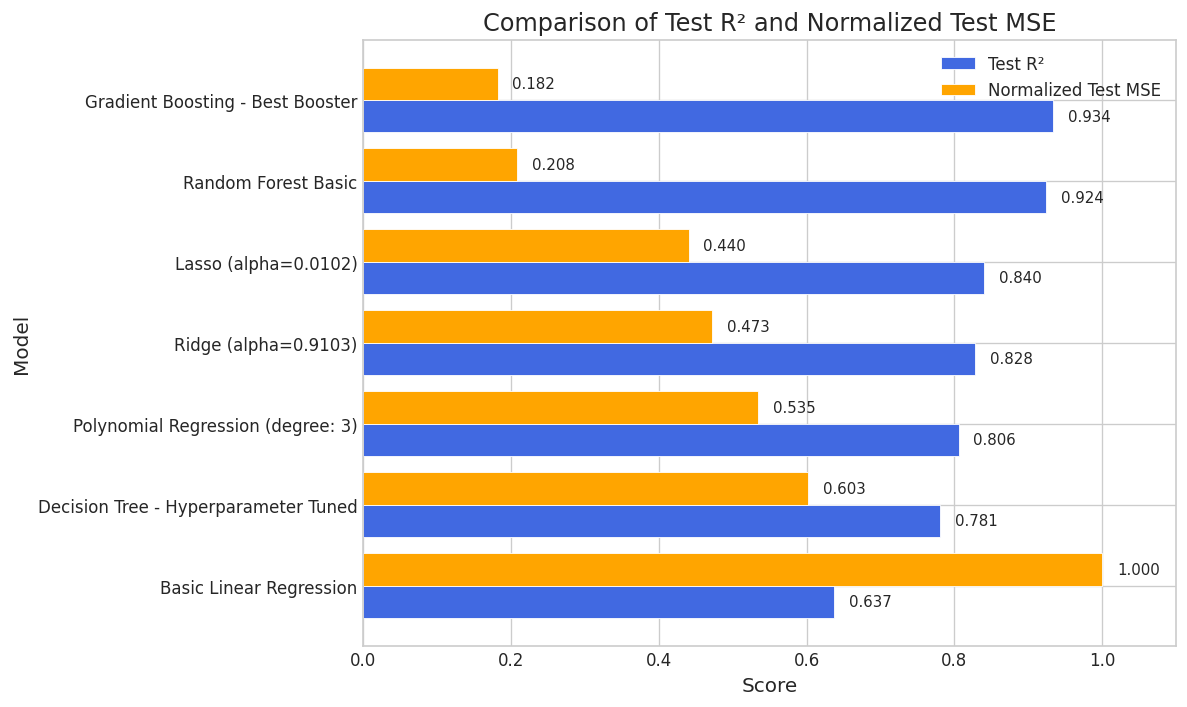

In [338]:
# normalize MSE
max_mse = model_results_df["Test_MSE"].max()
model_results_df["Test_MSE_norm"] = model_results_df["Test_MSE"] / max_mse

# Sort models by Test R² score for consistent bar order
sorted_df = model_results_df.sort_values("Test_R2", ascending=True)  

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
bar_height = 0.4
indices = np.arange(len(sorted_df))

plt.barh(indices, sorted_df["Test_R2"], bar_height, label="Test R²", color="royalblue")

plt.barh(indices + bar_height, sorted_df["Test_MSE_norm"], bar_height, label="Normalized Test MSE", color="orange")

plt.yticks(indices + bar_height / 2, sorted_df["Model"])
plt.ylabel("Model")
plt.title("Comparison of Test R² and Normalized Test MSE")
plt.xlim(0, 1.1)
plt.xlabel("Score")

# Add value labels next to each bar
for i in range(len(sorted_df)):
    plt.text(sorted_df["Test_R2"].iloc[i] + 0.02, i, f"{sorted_df['Test_R2'].iloc[i]:.3f}", va='center', fontsize=9)
    plt.text(sorted_df["Test_MSE_norm"].iloc[i] + 0.02, i + bar_height, f"{sorted_df['Test_MSE_norm'].iloc[i]:.3f}", va='center', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()

Among all the tested models, the **Gradient Boosting Regressor (Best Booster)** stands out as the optimal model. It achieves the **highest Test R²**, indicating the best fit and strongest explanatory power on the test data, and the **lowest normalized Test MSE**, reflecting superior predictive accuracy with minimal error.

This combination of the highest R² and the lowest normalized MSE confirms that the Best Booster model provides the most reliable and accurate predictions for our concrete compressive strength dataset. Therefore, it is the preferred choice for further analysis and deployment.


#### 4.2.2 Scatter Plot: Overfitting vs Generalization (Train R² vs Test R²)

This scatter plot illustrates the relationship between training and testing performance for various models, providing insight into how well each model fits the training data and how effectively it generalizes to unseen data.

The horizontal axis represents the training R² score, which measures the model's ability to explain variance in the training set. Higher values indicate a stronger fit to the training data. The vertical axis shows the testing R² score, reflecting the model’s predictive performance on unseen data. Again, higher values correspond to better generalization. Each point on the plot corresponds to a specific model. The size of the point is proportional to the gap between the training and testing R² scores. Larger points indicate a greater discrepancy, often signaling overfitting—where the model performs well on training data but poorly on test data. A dashed diagonal line represents the ideal case in which the training and testing R² scores are equal. Models positioned near this line demonstrate strong generalization, as their performance on unseen data closely matches their performance on the training data.

The plot is divided into several zones. The ideal zone, located in the upper right corner, contains models with both high training and testing R² values, indicating excellent fit and generalization. Models in the overfitting zone, found in the lower right, exhibit high training R² but low testing R², suggesting they have learned the training data too well at the expense of generalization. The underfitting zone, in the lower left, includes models with low R² scores on both sets, indicating poor performance overall. A less common but favorable region is the high generalization zone, where models show moderate training fit but surprisingly high test performance.

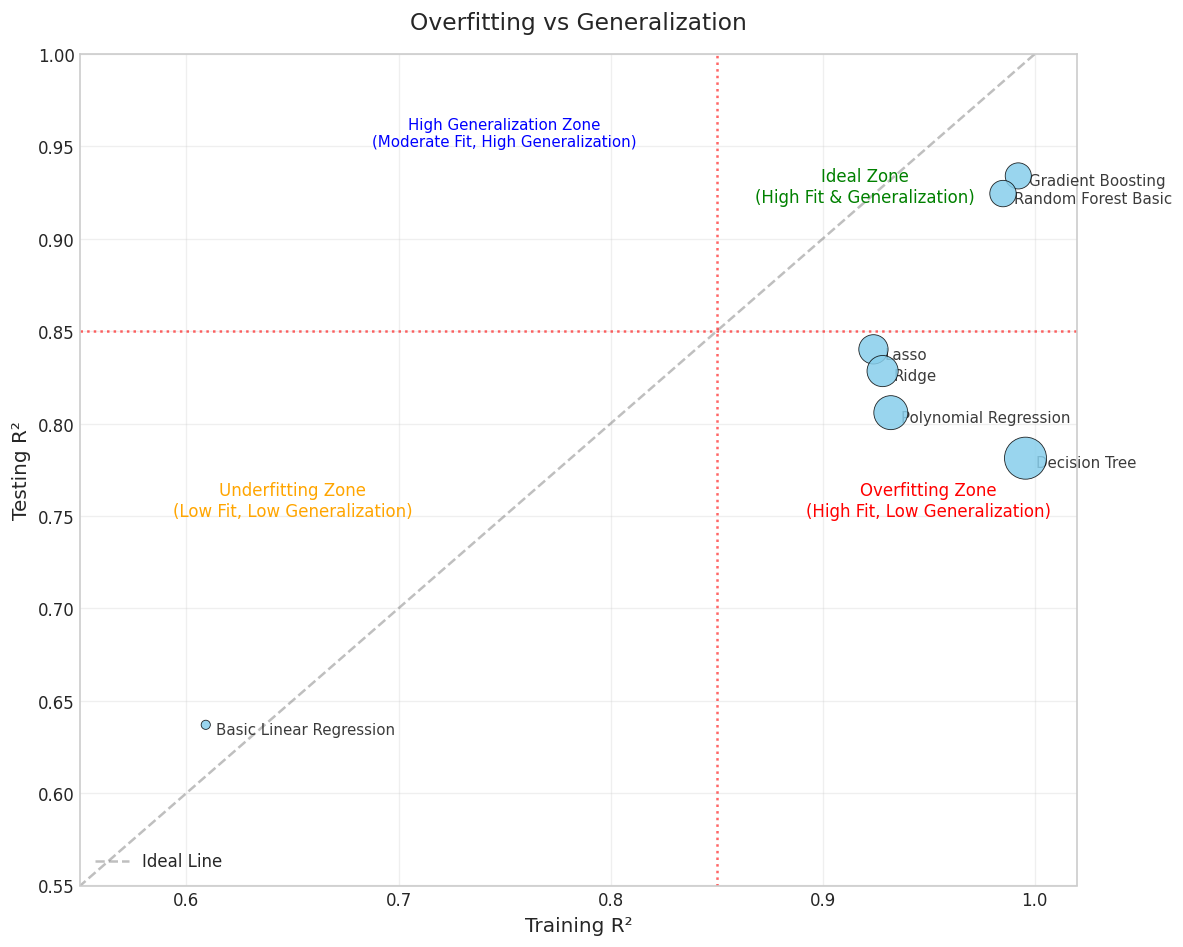

In [339]:
# Create a scatter plot to visualize model generalization vs overfitting
plt.figure(figsize=(10, 8))

scatter1 = plt.scatter(
    model_results_df['R2'], 
    model_results_df['Test_R2'], 
    s=model_results_df['R2_Gap']*2500 + 100, 
    color='skyblue',
    alpha=0.85,
    edgecolors='black',
    zorder=10
)

# Annotate each point with the model's short name
for i, row in model_results_df.iterrows():
    plt.annotate(row['ShortName'], 
                 (row['R2'] + 0.005, row['Test_R2'] - 0.005),
                 fontsize=9, alpha=0.9)

# Reference lines and zones for interpretation
plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5, label='Ideal Line')
plt.axvline(0.85, color='red', linestyle=':', alpha=0.6)
plt.axhline(0.85, color='red', linestyle=':', alpha=0.6)

plt.xlabel('Training R²', fontsize=12)
plt.ylabel('Testing R²', fontsize=12)
plt.title('Overfitting vs Generalization', fontsize=14, pad=15)

# text annotations to define interpretation zones
plt.text(0.92, 0.92, 'Ideal Zone\n(High Fit & Generalization)', 
         fontsize=10, color='green', ha='center')
plt.text(0.95, 0.75, 'Overfitting Zone\n(High Fit, Low Generalization)', 
         fontsize=10, color='red', ha='center')
plt.text(0.65, 0.75, 'Underfitting Zone\n(Low Fit, Low Generalization)', 
         fontsize=10, color='orange', ha='center')
plt.text(0.75, 0.95, 'High Generalization Zone\n(Moderate Fit, High Generalization)', 
         fontsize=9, color='blue', ha='center')

plt.xlim(0.55, 1.02)
plt.ylim(0.55, 1.0)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The Gradient Boosting model appears in the top-right corner of the scatter plot, demonstrating high R² values on both the training and testing sets. This placement indicates an excellent fit to the training data while maintaining strong generalization to unseen data. Although its point size is not the smallest, the relatively modest gap between training and testing R² suggests that overfitting is well-controlled, reflecting a strong balance between accuracy and generalization.

The Random Forest model also performs effectively, achieving a good trade-off between fitting the training data and generalizing to the test data. It is positioned close to the ideal region, supporting its status as a robust ensemble method.

In contrast, the Linear Regression model shows the smallest R² gap, as indicated by the smallest point size. However, both its training and testing R² values are comparatively lower than those of the ensemble models, suggesting limited overall predictive power despite consistent behavior across datasets.

The Decision Tree model demonstrates a very high R² on the training set but significantly lower performance on the test set. This large discrepancy is a typical sign of overfitting, where the model captures training noise rather than generalizable patterns.


#### 4.2.3 Scatter Plot: Train MSE vs Test MSE

This scatter plot compares the Mean Squared Error (MSE) of different models on the training and testing datasets, allowing for a direct assessment of both fit quality and generalization ability.

The horizontal axis displays the Train MSE, where lower values indicate that the model fits the training data more accurately. The vertical axis represents the Test MSE, with lower values suggesting better performance on unseen data.

A dashed diagonal line runs through the plot, marking the line of perfect generalization — where a model’s training and testing errors are equal. Models located near this line exhibit balanced generalization, as their performance is consistent across both datasets.

Models positioned in the bottom-left corner of the plot are ideal, as they demonstrate low error on both the training and testing sets, reflecting high accuracy and strong generalization. Models that appear well above the diagonal line typically suffer from overfitting, meaning they perform well on the training data but poorly on unseen data due to a lack of generalizability.

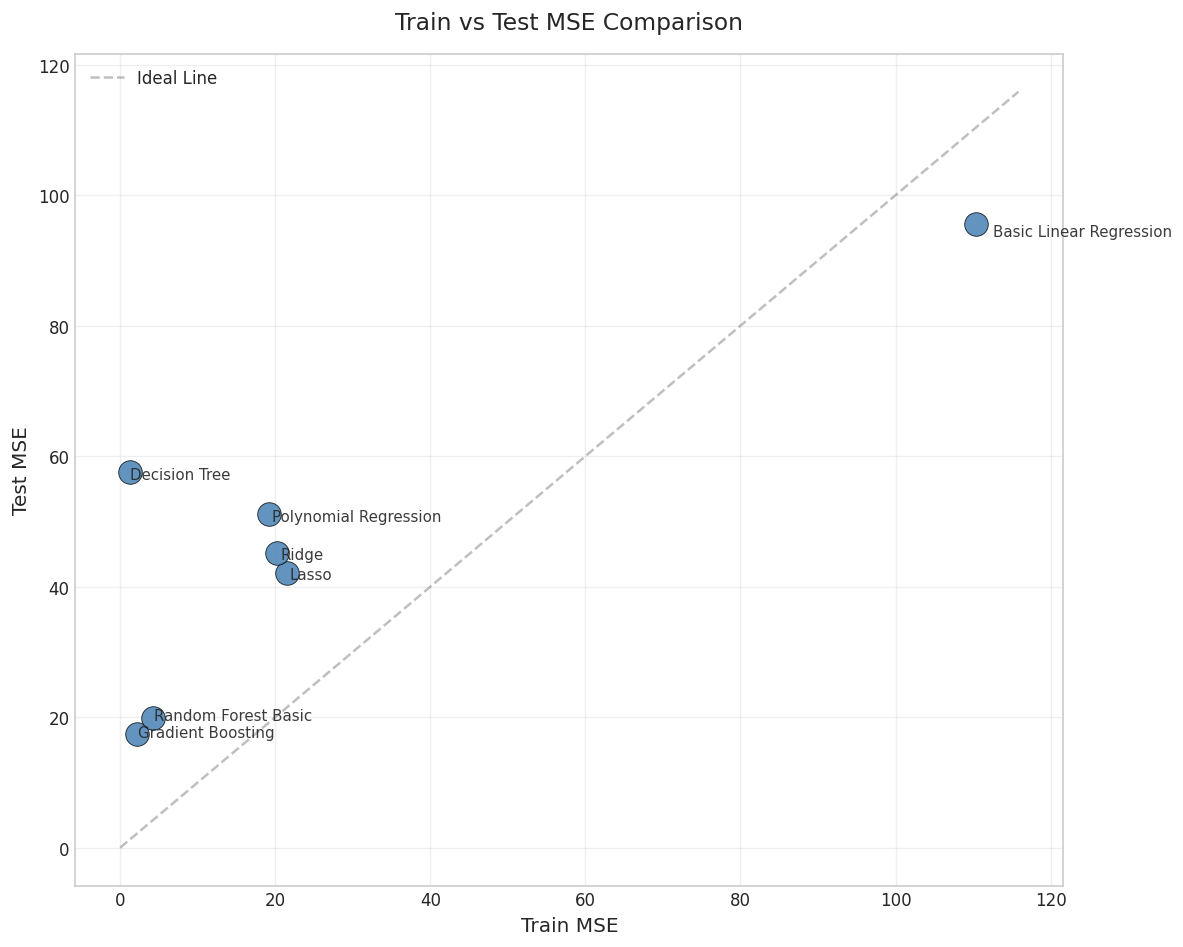

In [340]:
plt.figure(figsize=(10, 8))

scatter2 = plt.scatter(
    model_results_df['MSE'],      
    model_results_df['Test_MSE'], 
    s=200,                       
    color='steelblue',           
    edgecolors='black',
    alpha=0.85
)

for i, row in model_results_df.iterrows():
    plt.annotate(row['ShortName'], 
                 (row['MSE'] * 1.02, row['Test_MSE'] * 0.98),
                 fontsize=9, alpha=0.9)

max_mse = max(model_results_df['MSE'].max(), model_results_df['Test_MSE'].max()) * 1.05
plt.plot([0, max_mse], [0, max_mse], '--', color='gray', alpha=0.5, label='Ideal Line')

plt.xlabel('Train MSE', fontsize=12)
plt.ylabel('Test MSE', fontsize=12)
plt.title('Train vs Test MSE Comparison', fontsize=14, pad=15)

plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

The Gradient Boosting model is positioned closest to the bottom-left corner of the plot, achieving the lowest MSE on both the training and testing datasets. This indicates that it delivers excellent predictive accuracy while maintaining strong generalization performance.

The Random Forest model also appears near the bottom-left, reflecting low error on both datasets and confirming its status as a highly effective model with balanced generalization.

In contrast, the Decision Tree model shows a very low Train MSE but a significantly higher Test MSE. This large discrepancy suggests severe overfitting, where the model captures noise or specific patterns in the training data that do not transfer well to unseen data.

## 5. Conclusion

In this study, we explored the relationships between the composition of concrete mixtures and their corresponding compressive strength through data-driven analysis.

In **Chapter 1**, the problem under discussion is introduced and the objective of the study is defined.

In **Chapter 2**, the dataset was first preprocessed to ensure consistency and completeness. Subsequently, the distribution of the target variable and the correlations between relevant features were examined to support informed modeling decisions.

In **Chapter 3**, **cross-validation** was adopted as a fundamental evaluation strategy throughout the modeling process. Various regression models were assessed, beginning with **basic linear regression**, followed by **polynomial regression**, **feature selection**, and regularization techniques such as **Ridge** and **Lasso**. To further optimize prediction accuracy, **tree-based methods** — including **Decision Tree**, **Random Forest**, and **Gradient Boosting** — were also explored in parallel.

In **Chapter 4**, the discussion part includes comparison based on a summary table and four types of visualizations, indicating that the **best result** is from the **gradient boosting model**. Combining both the feature importance ranking and the PDP analysis, it can be concluded that Age, Cement, and Superplasticizer are the **most critical predictors** in the model — not only due to their high importance scores but also because of their clearly interpretable and consistent effects on the target variable.

If more time had been available, the project could have been extended in several directions. After looking up relevant literature and best practices, several promising techniques were identified for potential improvement. **From a modeling perspective**, more advanced regression methods such as **XGBoost, LightGBM, or stacked ensemble models** could have been applied to further enhance predictive accuracy. Additionally, **Bayesian Optimization and nested cross-validation** were identified as effective strategies for **more thorough hyperparameter tuning**, potentially improving model robustness and reducing overfitting. **From a theoretical standpoint**, consulting domain-specific literature could help clarify the relationships between variables—such as the chemical and physical roles of cementitious components—thereby enabling more meaningful feature engineering. This would help reduce data noise and enhance model interpretability. Lastly, conducting a more systematic residual analysis or error clustering might reveal persistent prediction issues and inspire targeted improvements to the model structure or input features.

Overall, the study offered a practical exploration of different modeling strategies for predicting concrete strength. Although the scope was limited, the results demonstrate the value of combining interpretability tools with machine learning models, which may serve as a basis for more in-depth research in the future.